# Table of Contents
 <p><div class="lev1"><a href="#Initialize-Environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev1"><a href="#Subgraph-of-Brain-Systems-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Subgraph of Brain Systems</a></div><div class="lev2"><a href="#Focal-vs-Distributed-Subgraphs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Focal vs Distributed Subgraphs</a></div><div class="lev2"><a href="#Formulate-ROI-Dict-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Formulate ROI Dict</a></div><div class="lev2"><a href="#Convert-ROI-Subgraphs-to-Brain-System-Subgraphs-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert ROI Subgraphs to Brain System Subgraphs</a></div><div class="lev2"><a href="#Between-Task-Subgraph-Contrast-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Between-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Within-Task-Subgraph-Contrast-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Within-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Subgraph-Expression-vs-Behavior-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Subgraph Expression vs Behavior</a></div><div class="lev3"><a href="#Load-Behavioral-Data-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Load Behavioral Data</a></div><div class="lev3"><a href="#Predicting-Interference-RT-(Hi)-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Predicting Interference RT (Hi)</a></div><div class="lev3"><a href="#Predicting-Cost-RT-(Hi-Lo)-2.6.3"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>Predicting Cost RT (Hi-Lo)</a></div><div class="lev3"><a href="#Predicting-Interference-Accuracy-(Hi)-2.6.4"><span class="toc-item-num">2.6.4&nbsp;&nbsp;</span>Predicting Interference Accuracy (Hi)</a></div><div class="lev3"><a href="#Predicting-Cost-Accuracy-(Hi-Lo)-2.6.5"><span class="toc-item-num">2.6.5&nbsp;&nbsp;</span>Predicting Cost Accuracy (Hi-Lo)</a></div>

# Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis_Notebooks/')

path_Remotes = '/home/akhambhati/JagHome/hoth_research'
path_CoreData = path_Remotes + '/CORE.fMRI_cogcontrol.medaglia'
path_RsrchData = path_Remotes + '/RSRCH.NMF_CogControl'
path_InpData = path_RsrchData + '/e02b-FuncSubg'
path_ExpData = path_RsrchData + '/e04b-FuncSubg_Dynamics'

for path in [path_CoreData, path_RsrchData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Subgraph of Brain Systems

In [2]:
df_nmf = np.load('{}/NMF_Consensus.npz'.format(path_InpData), mmap_mode='r')
fac_subnet = df_nmf['fac_subnet']
fac_coef = df_nmf['fac_coef']
n_fac = fac_subnet.shape[0]
n_conn = fac_subnet.shape[1]
n_obs = fac_coef.shape[1]

## Focal vs Distributed Subgraphs

(0, 54)

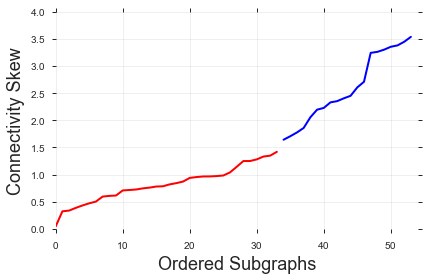

In [129]:
real_subg_skew = np.array([stats.skew(subg) for subg in fac_subnet])
real_ix = np.argsort(real_subg_skew)

n_null = 10000
#coef_dist = fac_coef.reshape(-1)
#rnd_coef = np.array([np.random.permutation(coef_dist)[:54] for i in xrange(n_null)])
rnd_coef = np.random.uniform(size=(n_null, n_fac))
rnd_subnet = np.dot(rnd_coef, fac_subnet)

rnd_subg_skew = np.array([stats.skew(subg) for subg in rnd_subnet])
rnd_ix = np.argsort(rnd_subg_skew)

thresh = np.percentile(rnd_subg_skew, 100)
low_ix = np.flatnonzero(real_subg_skew[real_ix] <= thresh)
high_ix = np.flatnonzero(real_subg_skew[real_ix] > thresh)

%matplotlib inline
plt.figure()
ax = plt.subplot(111)
ax.plot(low_ix, real_subg_skew[real_ix][low_ix], color='r')
ax.plot(high_ix, real_subg_skew[real_ix][high_ix], color='b')
ax.set_xlabel('Ordered Subgraphs')
ax.set_ylabel('Connectivity Skew')
ax.set_xlim([0, n_fac])

## Formulate ROI Dict

In [3]:
df_parcel = pd.read_csv('{}/LausanneScale125.csv'.format(path_CoreData))

all_roi_names = []

roi_dict = {}
for lbl_id, lbl_roi, lbl_hemi in zip(df_parcel.Label_ID, df_parcel.ROI, df_parcel.Hemisphere):
    roi_name = '{}_{}'.format(lbl_hemi, lbl_roi.split('_')[0])
    #roi_name = lbl_roi.split('_')[0]
    
    if roi_name not in all_roi_names:
        all_roi_names.append(roi_name)

    try:
        roi_dict[roi_name]
    except KeyError:
        roi_dict[roi_name] = []

    roi_dict[roi_name].append(lbl_id-1)
n_roi = len(all_roi_names)
n_conn_roi = int(n_roi*(n_roi-1)*0.5)

## Convert ROI Subgraphs to Brain System Subgraphs

In [4]:
bs_fac_subnet = np.zeros((n_fac, n_conn_roi))
for fac_i, subg in enumerate(fac_subnet):
    adj = conv_cfg_vec_to_adj_matr(subg)
    
    tmp_subnet = np.zeros((1, n_roi, n_roi))
    for ij_ii, ij_roi in enumerate(all_roi_names):
        for ik_ii, ik_roi in enumerate(all_roi_names):
            
            mean_conn = adj[roi_dict[ij_roi], :][:, roi_dict[ik_roi]].mean()
            tmp_subnet[0, ij_ii, ik_ii] = mean_conn
    bs_fac_subnet[fac_i, :] = conv_adj_matr_to_cfg_matr(tmp_subnet)[0, :]

## Between-Task Subgraph Contrast

0.0069444444
****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen
    LH_thalamusproper
    RH_lateraloccipital
    RH_fusiform
    RH_precentral
    RH_thalamusproper
    LH_caudate

    Pos-Stroop-Navon: ts: -3.368941 pval: 0.002284 sig: *
    Neg-Stroop-Navon: ts: 1.690918 pval: 0.102366 sig: 


/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


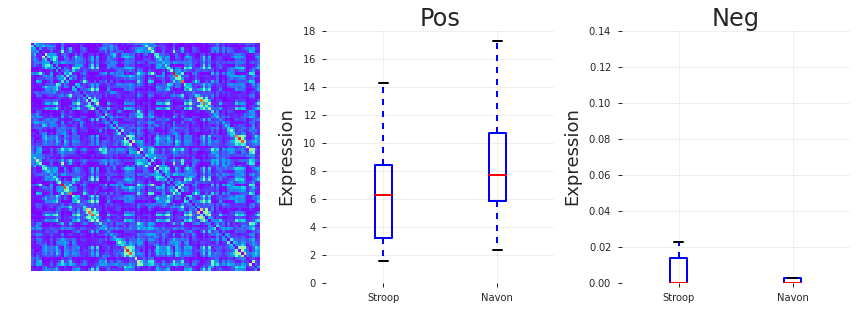





****************************** Subgraph 15 ******************************
    LH_parstriangularis
    RH_rostralmiddlefrontal
    RH_parsopercularis
    RH_putamen
    LH_parsopercularis
    RH_parstriangularis
    LH_putamen
    LH_caudate
    LH_bankssts
    RH_inferiorparietal
    RH_caudalanteriorcingulate
    LH_rostralmiddlefrontal

    Pos-Stroop-Navon: ts: -6.213510 pval: 0.000001 sig: *
    Neg-Stroop-Navon: ts: 4.282018 pval: 0.000209 sig: *


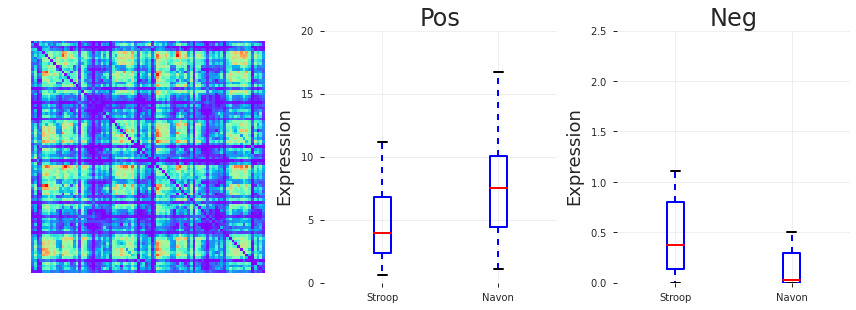





****************************** Subgraph 17 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual
    RH_isthmuscingulate
    RH_precuneus
    LH_isthmuscingulate
    RH_hyppocampus
    LH_rostralanteriorcingulate
    LH_precuneus

    Pos-Stroop-Navon: ts: 3.659749 pval: 0.001081 sig: *
    Neg-Stroop-Navon: ts: -1.039642 pval: 0.307727 sig: 


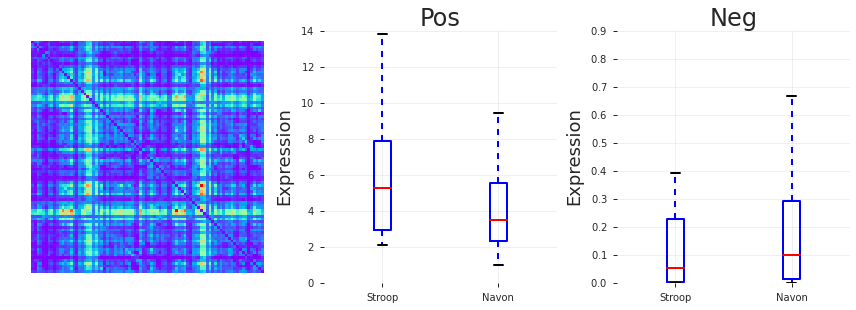





****************************** Subgraph 18 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual
    LH_lateraloccipital
    RH_lateraloccipital
    LH_superiorparietal
    RH_superiorparietal
    RH_parsopercularis
    RH_precuneus

    Pos-Stroop-Navon: ts: -6.613368 pval: 0.000000 sig: *
    Neg-Stroop-Navon: ts: 2.638314 pval: 0.013660 sig: 


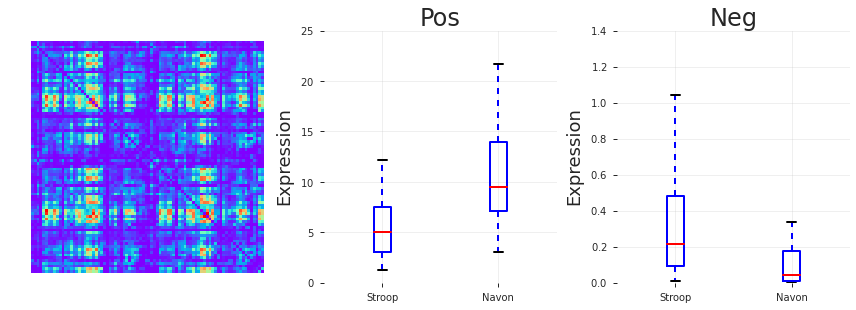

In [5]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Pos': {'Stroop': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                   'Navon': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon']},
           'Neg': {'Stroop': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop'],
                   'Navon': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Pos', 'Neg']
key_order = ['Stroop', 'Navon']

sel_fac_ix = np.arange(n_fac)

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():
        subplot_dict = {'title': grp,
                        'xlabel': [],
                        'distrib': [],
                        'stats': []}
        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)

            mean_subj_coef = 0.5*(np.mean(subj_hi, axis=1) + np.mean(subj_lo, axis=1))
            
            subplot_dict['xlabel'].append(key)
            subplot_dict['distrib'].append(mean_subj_coef)
        
        for key_pair in [[0,1]]:
            ts, pv = stats.ttest_rel(subplot_dict['distrib'][key_pair[0]],
                                     subplot_dict['distrib'][key_pair[1]])      
            subplot_dict['stats'].append({'name': '{}-{}'.format(subplot_dict['xlabel'][key_pair[0]],
                                                                 subplot_dict['xlabel'][key_pair[1]]),
                                          'tstat': ts,
                                          'pval': pv,
                                          'sig': ''})
            
        plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_stat['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']
                    for fac_stat in fac_subp['stats']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
sel_fac_between_sig = []
for fac_ii, fac_plot in enumerate(plot_list):
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        for fac_stat in fac_subp['stats']:
            if fac_stat['pval'] < adj_alpha:
                fac_stat['sig'] = '*'
                sel_fac_between_sig.append(fac_ii)
            pval_list.append(fac_stat['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)
sel_fac_between_sig = np.unique(sel_fac_between_sig)

# Plot each result
for fac_ix in sel_fac_between_sig:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2, 3]
    
    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(12)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        ax.boxplot(fac_subp['distrib'])
        ax.set_xticklabels(fac_subp['xlabel'])
        ax.set_ylabel('Expression')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        for fac_stat in fac_subp['stats']:
            print('    %s-%s: ts: %0.6f pval: %0.6f sig: %s' % 
                  (fac_subp['title'], fac_stat['name'],
                   fac_stat['tstat'], fac_stat['pval'],
                   fac_stat['sig']))        
            
    plt.show()
    print('\n\n\n')

## Within-Task Subgraph Contrast

0.0097222222
****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

      Stroop_Pos: Lo-Rs: ts: 1.153626 pval: 0.129382 sig: 
      Stroop_Pos: Hi-Rs: ts: 2.286573 pval: 0.015143 sig: 
      Stroop_Pos: Hi-Lo: ts: 1.760454 pval: 0.044828 sig: 

       Navon_Pos: Lo-Rs: ts: 1.664668 pval: 0.053772 sig: 
       Navon_Pos: Hi-Rs: ts: 3.963542 pval: 0.000244 sig: *
       Navon_Pos: Hi-Lo: ts: 2.160580 pval: 0.019883 sig: 

      Stroop_Neg: Lo-Rs: ts: -0.492956 pval: 0.313015 sig: 
      Stroop_Neg: Hi-Rs: ts: -1.356612 pval: 0.093070 sig: 
      Stroop_Neg: Hi-Lo: ts: -1.542818 pval: 0.067258 sig: 

       Navon_Neg: Lo-Rs: ts: -2.606156 pval: 0.007361 sig: 
       Navon_Neg: Hi-Rs: ts: -2.793700 pval: 0.004733 sig: 
       Navon_Neg: Hi-Lo: ts: -0.447812 pval: 0.328931 sig: 



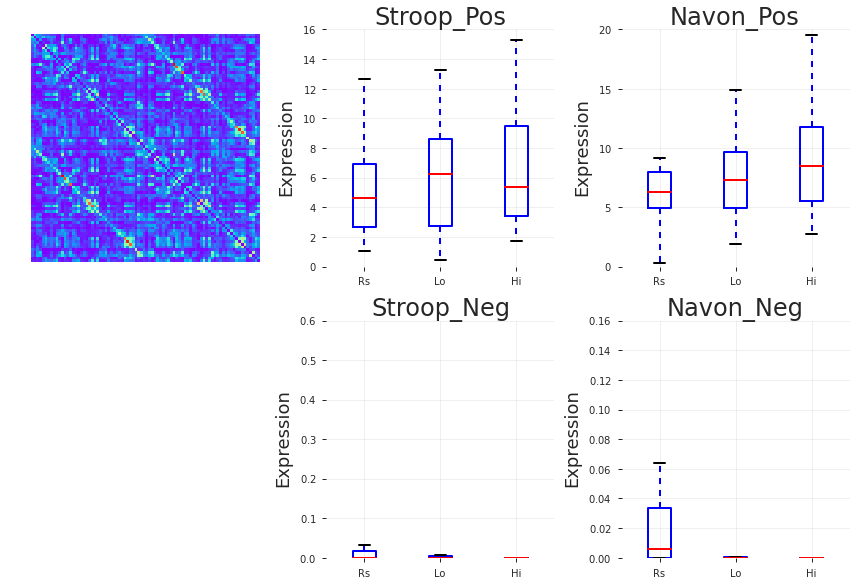





****************************** Subgraph 4 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

      Stroop_Pos: Lo-Rs: ts: -1.417242 pval: 0.083925 sig: 
      Stroop_Pos: Hi-Rs: ts: -0.878697 pval: 0.193660 sig: 
      Stroop_Pos: Hi-Lo: ts: 0.716045 pval: 0.240056 sig: 

       Navon_Pos: Lo-Rs: ts: 0.317220 pval: 0.376758 sig: 
       Navon_Pos: Hi-Rs: ts: -0.851780 pval: 0.200914 sig: 
       Navon_Pos: Hi-Lo: ts: -1.132744 pval: 0.133641 sig: 

      Stroop_Neg: Lo-Rs: ts: 2.630773 pval: 0.006951 sig: *
      Stroop_Neg: Hi-Rs: ts: 2.559760 pval: 0.008194 sig: *
      Stroop_Neg: Hi-Lo: ts: -0.362682 pval: 0.359833 sig: 

       Navon_Neg: Lo-Rs: ts: 2.159704 pval: 0.019920 sig: 
       Navon_Neg: Hi-Rs: ts: 3.369087 pval: 0.001142 sig: *
       Navon_Neg: Hi-Lo: ts: 1.498554 pval: 0.072796 sig: 



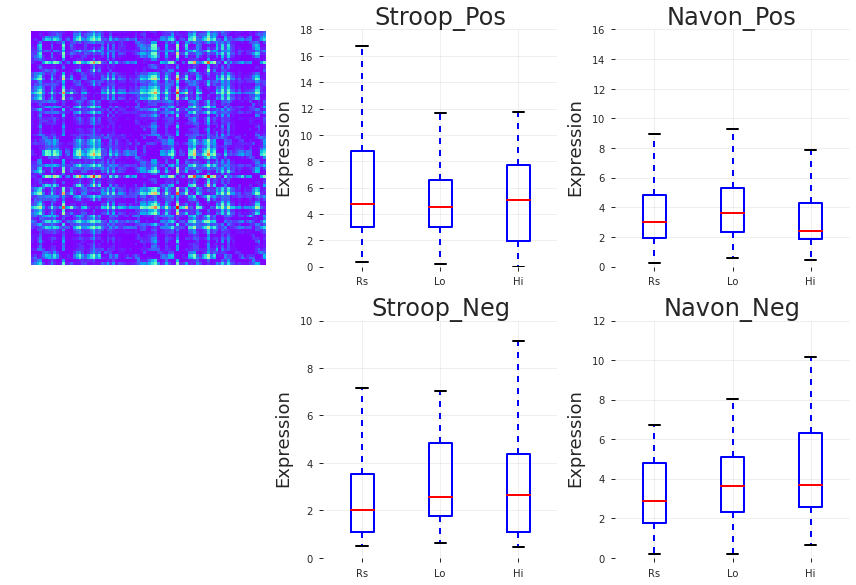





****************************** Subgraph 9 ******************************
    LH_paracentral
    LH_hyppocampus
    RH_paracentral
    LH_amygdala
    LH_rostralanteriorcingulate
    LH_medialorbitofrontal

      Stroop_Pos: Lo-Rs: ts: 1.063497 pval: 0.148488 sig: 
      Stroop_Pos: Hi-Rs: ts: 1.770362 pval: 0.043980 sig: 
      Stroop_Pos: Hi-Lo: ts: 1.256450 pval: 0.109858 sig: 

       Navon_Pos: Lo-Rs: ts: 3.599840 pval: 0.000631 sig: *
       Navon_Pos: Hi-Rs: ts: 3.034233 pval: 0.002641 sig: *
       Navon_Pos: Hi-Lo: ts: 0.091754 pval: 0.463785 sig: 

      Stroop_Neg: Lo-Rs: ts: -0.054344 pval: 0.478531 sig: 
      Stroop_Neg: Hi-Rs: ts: -0.304428 pval: 0.381568 sig: 
      Stroop_Neg: Hi-Lo: ts: -0.403052 pval: 0.345042 sig: 

       Navon_Neg: Lo-Rs: ts: -0.947558 pval: 0.175879 sig: 
       Navon_Neg: Hi-Rs: ts: -0.794254 pval: 0.216987 sig: 
       Navon_Neg: Hi-Lo: ts: -0.015135 pval: 0.494018 sig: 



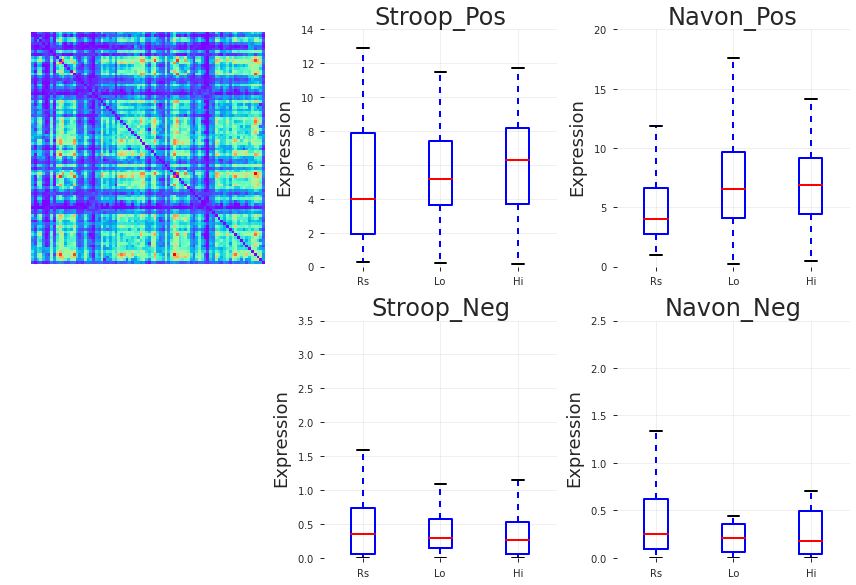





****************************** Subgraph 10 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

      Stroop_Pos: Lo-Rs: ts: 0.308114 pval: 0.380180 sig: 
      Stroop_Pos: Hi-Rs: ts: 2.798674 pval: 0.004677 sig: *
      Stroop_Pos: Hi-Lo: ts: 3.833365 pval: 0.000343 sig: *

       Navon_Pos: Lo-Rs: ts: 3.143525 pval: 0.002015 sig: *
       Navon_Pos: Hi-Rs: ts: 3.420095 pval: 0.001002 sig: *
       Navon_Pos: Hi-Lo: ts: 0.924010 pval: 0.181833 sig: 

      Stroop_Neg: Lo-Rs: ts: 0.892966 pval: 0.189883 sig: 
      Stroop_Neg: Hi-Rs: ts: -1.706716 pval: 0.049676 sig: 
      Stroop_Neg: Hi-Lo: ts: -1.782291 pval: 0.042976 sig: 

       Navon_Neg: Lo-Rs: ts: -1.986442 pval: 0.028610 sig: 
       Navon_Neg: Hi-Rs: ts: -2.503373 pval: 0.009325 sig: 
       Navon_Neg: Hi-Lo: ts: -0.536899 pval: 0.297867 sig: 



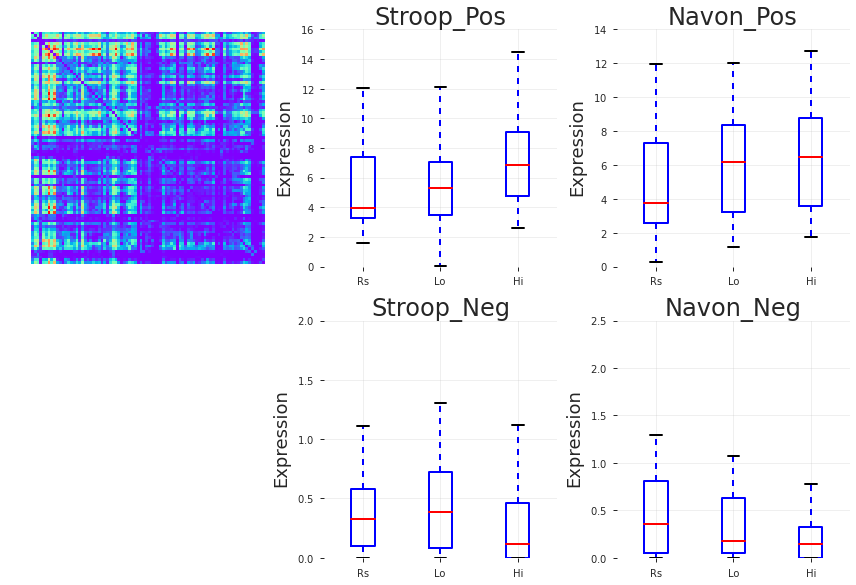





****************************** Subgraph 12 ******************************
    LH_parstriangularis
    LH_parsopercularis
    LH_caudalmiddlefrontal
    LH_bankssts
    LH_parsorbitalis
    LH_rostralmiddlefrontal

      Stroop_Pos: Lo-Rs: ts: -1.211434 pval: 0.118113 sig: 
      Stroop_Pos: Hi-Rs: ts: 2.840443 pval: 0.004232 sig: *
      Stroop_Pos: Hi-Lo: ts: 4.058683 pval: 0.000189 sig: *

       Navon_Pos: Lo-Rs: ts: 1.209805 pval: 0.118420 sig: 
       Navon_Pos: Hi-Rs: ts: 1.582242 pval: 0.062620 sig: 
       Navon_Pos: Hi-Lo: ts: 0.077645 pval: 0.469341 sig: 

      Stroop_Neg: Lo-Rs: ts: 1.745822 pval: 0.046107 sig: 
      Stroop_Neg: Hi-Rs: ts: -2.019223 pval: 0.026747 sig: 
      Stroop_Neg: Hi-Lo: ts: -3.006765 pval: 0.002826 sig: 

       Navon_Neg: Lo-Rs: ts: 0.127470 pval: 0.449757 sig: 
       Navon_Neg: Hi-Rs: ts: 0.272734 pval: 0.393566 sig: 
       Navon_Neg: Hi-Lo: ts: 0.113619 pval: 0.455190 sig: 



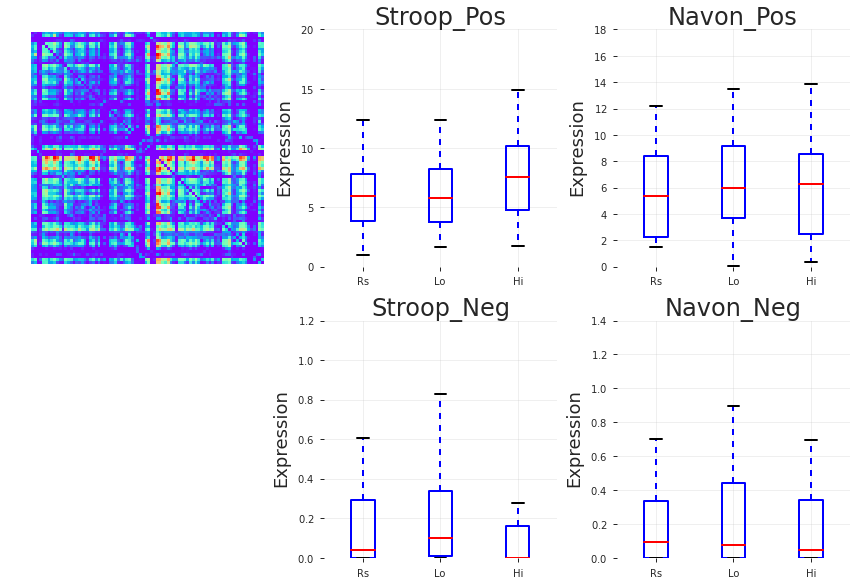





****************************** Subgraph 13 ******************************
    LH_frontalpole
    LH_parahippocampal
    RH_frontalpole
    LH_isthmuscingulate
    RH_parahippocampal
    LH_posteriorcingulate

      Stroop_Pos: Lo-Rs: ts: 1.842738 pval: 0.038187 sig: 
      Stroop_Pos: Hi-Rs: ts: 4.215532 pval: 0.000125 sig: *
      Stroop_Pos: Hi-Lo: ts: 1.448358 pval: 0.079516 sig: 

       Navon_Pos: Lo-Rs: ts: 1.455811 pval: 0.078488 sig: 
       Navon_Pos: Hi-Rs: ts: 1.182134 pval: 0.123730 sig: 
       Navon_Pos: Hi-Lo: ts: -0.243458 pval: 0.404745 sig: 

      Stroop_Neg: Lo-Rs: ts: -1.565563 pval: 0.064549 sig: 
      Stroop_Neg: Hi-Rs: ts: -2.063191 pval: 0.024416 sig: 
      Stroop_Neg: Hi-Lo: ts: -0.635104 pval: 0.265353 sig: 

       Navon_Neg: Lo-Rs: ts: -1.051168 pval: 0.151250 sig: 
       Navon_Neg: Hi-Rs: ts: 0.807243 pval: 0.213291 sig: 
       Navon_Neg: Hi-Lo: ts: 1.418397 pval: 0.083758 sig: 



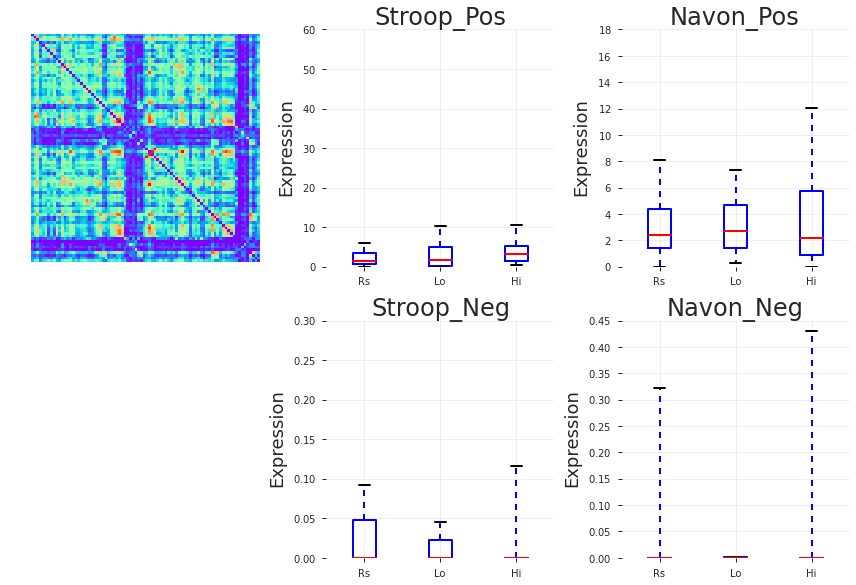





****************************** Subgraph 14 ******************************
    RH_paracentral
    LH_paracentral
    LH_cuneus
    LH_lingual
    RH_postcentral
    RH_precentral

      Stroop_Pos: Lo-Rs: ts: 3.353511 pval: 0.001188 sig: *
      Stroop_Pos: Hi-Rs: ts: 3.717077 pval: 0.000465 sig: *
      Stroop_Pos: Hi-Lo: ts: 0.523263 pval: 0.302530 sig: 

       Navon_Pos: Lo-Rs: ts: 5.747332 pval: 0.000002 sig: *
       Navon_Pos: Hi-Rs: ts: 3.813216 pval: 0.000362 sig: *
       Navon_Pos: Hi-Lo: ts: -0.468869 pval: 0.321463 sig: 

      Stroop_Neg: Lo-Rs: ts: 1.244514 pval: 0.112003 sig: 
      Stroop_Neg: Hi-Rs: ts: 0.020339 pval: 0.491961 sig: 
      Stroop_Neg: Hi-Lo: ts: -1.605395 pval: 0.060021 sig: 

       Navon_Neg: Lo-Rs: ts: -0.003610 pval: 0.498573 sig: 
       Navon_Neg: Hi-Rs: ts: -0.250999 pval: 0.401857 sig: 
       Navon_Neg: Hi-Lo: ts: -0.371744 pval: 0.356493 sig: 



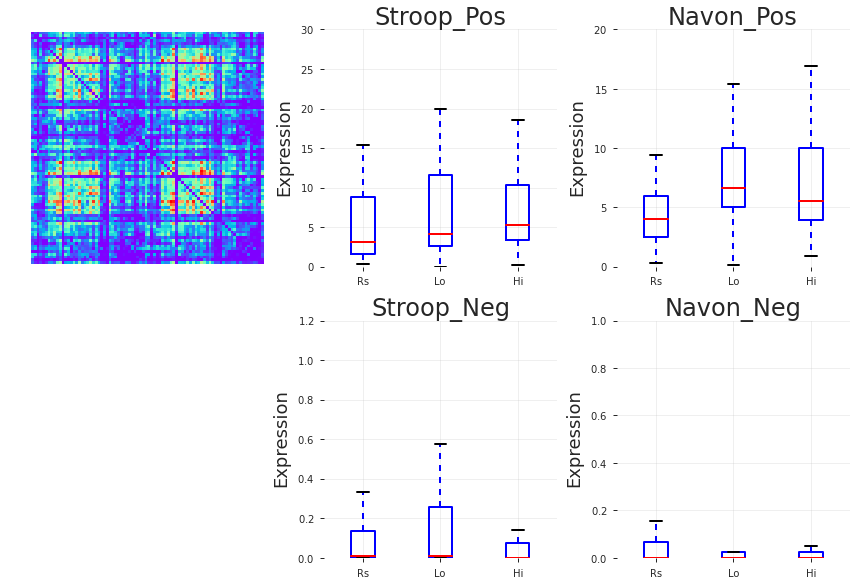





****************************** Subgraph 16 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

      Stroop_Pos: Lo-Rs: ts: -1.450328 pval: 0.079243 sig: 
      Stroop_Pos: Hi-Rs: ts: -1.431701 pval: 0.081852 sig: 
      Stroop_Pos: Hi-Lo: ts: 0.417896 pval: 0.339664 sig: 

       Navon_Pos: Lo-Rs: ts: 1.142592 pval: 0.131620 sig: 
       Navon_Pos: Hi-Rs: ts: -0.443835 pval: 0.330349 sig: 
       Navon_Pos: Hi-Lo: ts: -1.852734 pval: 0.037441 sig: 

      Stroop_Neg: Lo-Rs: ts: 2.450695 pval: 0.010510 sig: 
      Stroop_Neg: Hi-Rs: ts: 2.723339 pval: 0.005594 sig: *
      Stroop_Neg: Hi-Lo: ts: 0.003412 pval: 0.498651 sig: 

       Navon_Neg: Lo-Rs: ts: 1.234417 pval: 0.113842 sig: 
       Navon_Neg: Hi-Rs: ts: 3.329462 pval: 0.001263 sig: *
       Navon_Neg: Hi-Lo: ts: 2.546140 pval: 0.008455 sig: *



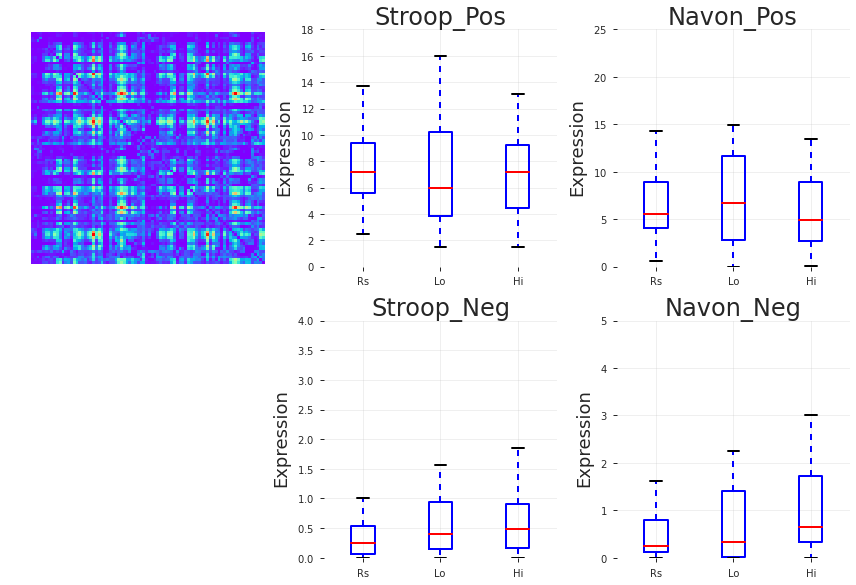





****************************** Subgraph 17 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

      Stroop_Pos: Lo-Rs: ts: 1.067367 pval: 0.147629 sig: 
      Stroop_Pos: Hi-Rs: ts: -0.004270 pval: 0.498312 sig: 
      Stroop_Pos: Hi-Lo: ts: -1.151813 pval: 0.129748 sig: 

       Navon_Pos: Lo-Rs: ts: -3.173100 pval: 0.001872 sig: 
       Navon_Pos: Hi-Rs: ts: -5.584953 pval: 0.000003 sig: 
       Navon_Pos: Hi-Lo: ts: -2.861051 pval: 0.004027 sig: 

      Stroop_Neg: Lo-Rs: ts: -1.607664 pval: 0.059771 sig: 
      Stroop_Neg: Hi-Rs: ts: -0.862080 pval: 0.198118 sig: 
      Stroop_Neg: Hi-Lo: ts: 0.583581 pval: 0.282173 sig: 

       Navon_Neg: Lo-Rs: ts: 0.683685 pval: 0.250000 sig: 
       Navon_Neg: Hi-Rs: ts: 2.946850 pval: 0.003271 sig: *
       Navon_Neg: Hi-Lo: ts: 2.138416 pval: 0.020843 sig: 



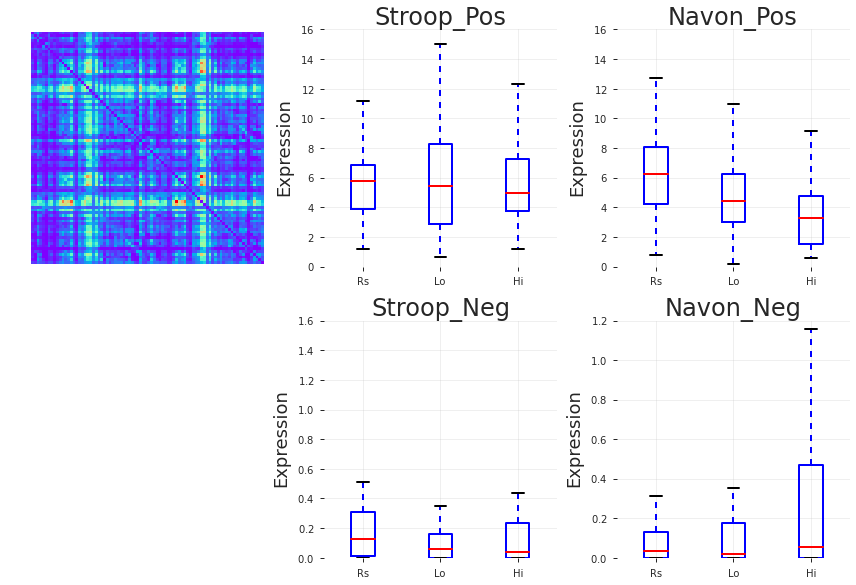





****************************** Subgraph 18 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

      Stroop_Pos: Lo-Rs: ts: 0.995171 pval: 0.164244 sig: 
      Stroop_Pos: Hi-Rs: ts: 2.122745 pval: 0.021546 sig: 
      Stroop_Pos: Hi-Lo: ts: 1.813966 pval: 0.040406 sig: 

       Navon_Pos: Lo-Rs: ts: 3.407552 pval: 0.001035 sig: *
       Navon_Pos: Hi-Rs: ts: 4.651155 pval: 0.000039 sig: *
       Navon_Pos: Hi-Lo: ts: 2.381626 pval: 0.012273 sig: 

      Stroop_Neg: Lo-Rs: ts: 0.225942 pval: 0.411474 sig: 
      Stroop_Neg: Hi-Rs: ts: -1.515704 pval: 0.070608 sig: 
      Stroop_Neg: Hi-Lo: ts: -1.511036 pval: 0.071198 sig: 

       Navon_Neg: Lo-Rs: ts: -0.102647 pval: 0.459501 sig: 
       Navon_Neg: Hi-Rs: ts: 0.120156 pval: 0.452625 sig: 
       Navon_Neg: Hi-Lo: ts: 0.349539 pval: 0.364698 sig: 



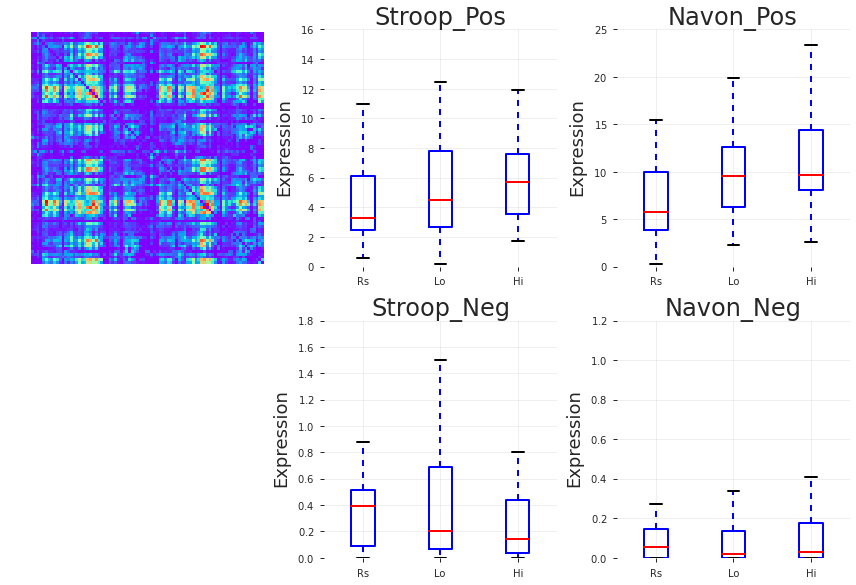

In [6]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop_Pos': {'Rs': ['adj_rs_pos_Stroop'],
                          'Lo': ['adj_lo_pos_Stroop'],
                          'Hi': ['adj_hi_pos_Stroop']},
           'Navon_Pos' : {'Rs': ['adj_rs_pos_Navon'],
                          'Lo': ['adj_lo_pos_Navon'],
                          'Hi': ['adj_hi_pos_Navon']},
           'Stroop_Neg': {'Rs': ['adj_rs_neg_Stroop'],
                          'Lo': ['adj_lo_neg_Stroop'],
                          'Hi': ['adj_hi_neg_Stroop']},
           'Navon_Neg' : {'Rs': ['adj_rs_neg_Navon'],
                          'Lo': ['adj_lo_neg_Navon'],
                          'Hi': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop_Pos', 'Navon_Pos', 'Stroop_Neg', 'Navon_Neg']
key_order = ['Rs', 'Lo', 'Hi']

sel_fac_ix = np.arange(n_fac)

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():
        subplot_dict = {'title': grp,
                        'xlabel': [],
                        'distrib': [],
                        'stats': []}
        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)

            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            subplot_dict['xlabel'].append(key)
            subplot_dict['distrib'].append(mean_subj_coef)
            
        for key_pair in [[1,0], [2,0], [2,1]]:
            ts, pv = stats.ttest_rel(subplot_dict['distrib'][key_pair[0]],
                                     subplot_dict['distrib'][key_pair[1]])      
            subplot_dict['stats'].append({'name': '{}-{}'.format(subplot_dict['xlabel'][key_pair[0]],
                                                                 subplot_dict['xlabel'][key_pair[1]]),
                                          'tstat': ts,
                                          'pval': pv/2.0,
                                          'sig': ''})        
        
        plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_stat['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']
                    for fac_stat in fac_subp['stats']])[::-1]

alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
sel_fac_within_sig = []
for fac_ii, fac_plot in enumerate(plot_list):
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        for fac_stat in fac_subp['stats']:
            if (fac_stat['pval'] < adj_alpha) & (fac_stat['tstat'] > 0):
                fac_stat['sig'] = '*'
                sel_fac_within_sig.append(fac_ii)
            pval_list.append(fac_stat['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)
sel_fac_within_sig = np.unique(sel_fac_within_sig)

# Plot each result
for fac_ix in sel_fac_within_sig:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]
    
    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        ax.boxplot(fac_subp['distrib'])
        ax.set_xticklabels(fac_subp['xlabel'])
        ax.set_ylabel('Expression')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        for fac_stat in fac_subp['stats']:
            print('    %12s: %s: ts: %0.6f pval: %0.6f sig: %s' % 
                  (fac_subp['title'], fac_stat['name'],
                   fac_stat['tstat'], fac_stat['pval'],
                   fac_stat['sig']))
        print('')
            
    plt.show()
    print('\n\n\n')

## Subgraph Expression vs Behavior

### Load Behavioral Data

In [7]:
df_beh = io.loadmat('{}/BehavioralData_CogControlCorrect.mat'.format(path_CoreData))

stroop_lbl = [lbl[0] for lbl in df_beh['StroopLabels'][0]]
navon_lbl = [lbl[0] for lbl in df_beh['NavonLabels'][0]]
stroop_beh = df_beh['StroopCorrectOnly']
navon_beh = df_beh['NavonCorrectOnly']

# Removed subjects
bad_subj_ix = [1, 6]
good_subj_ix = np.setdiff1d(np.arange(stroop_beh.shape[0]), bad_subj_ix)

# Excessive movement
stroop_move = io.loadmat('{}/StroopMove.mat'.format(path_CoreData))['move'][:, 0]
navon_move = io.loadmat('{}/NavonMove.mat'.format(path_CoreData))['move'][:, 0]

# Reaction Time
stroop_interf_rt = stroop_beh[good_subj_ix, 5]
navon_interf_rt = navon_beh[good_subj_ix, 5]

stroop_noninterf_rt = stroop_beh[good_subj_ix, 7]
navon_noninterf_rt = navon_beh[good_subj_ix, 7]

stroop_cost_rt = stroop_interf_rt - stroop_noninterf_rt
navon_cost_rt = navon_interf_rt - navon_noninterf_rt

# Accuracy
stroop_interf_acc = stroop_beh[good_subj_ix, 1]
navon_interf_acc = navon_beh[good_subj_ix, 1]

stroop_noninterf_acc = stroop_beh[good_subj_ix, 2]
navon_noninterf_acc = navon_beh[good_subj_ix, 2]

stroop_cost_acc = stroop_noninterf_acc - stroop_interf_acc
navon_cost_acc = navon_noninterf_acc - navon_interf_acc

print('Stroop Labels: {}'.format(stroop_lbl))
print('Navon Labels: {}'.format(navon_lbl))

Stroop Labels: [u'Total Accuracy', u'Interference Accuracy', u'NoInterference Accuracy', u'MeanRT', u'MedianRT', u'InterferenceMeanRT', u'InterferenceMedianRT', u'NoInterferenceMeanRT', u'NoInterferenceMedianRT', u'InterferenceMedianRTMinusMeanRT']
Navon Labels: [u'Total Accuracy', u'ShiftingAccuracy', u'NoShiftingAccuracy', u'MeanRT', u'MedianRT', u'ShiftingMeanRT', u'ShiftingMedianRT', u'NoShiftingMeanRT', u'NoShiftingMedianRT', u'ProportionTotalNonResponses']


### Predicting Interference RT (Hi)

0.0012500000
****************************** Subgraph 8 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

    Stroop: Hi_Pos: rho: 0.06065 pval: 0.38920 sig: 
    Stroop: Hi_Neg: rho: 0.12706 pval: 0.25920 sig: 
    Navon: Hi_Pos: rho: -0.16880 pval: 0.19860 sig: 
    Navon: Hi_Neg: rho: 0.46211 pval: 0.00990 sig: 


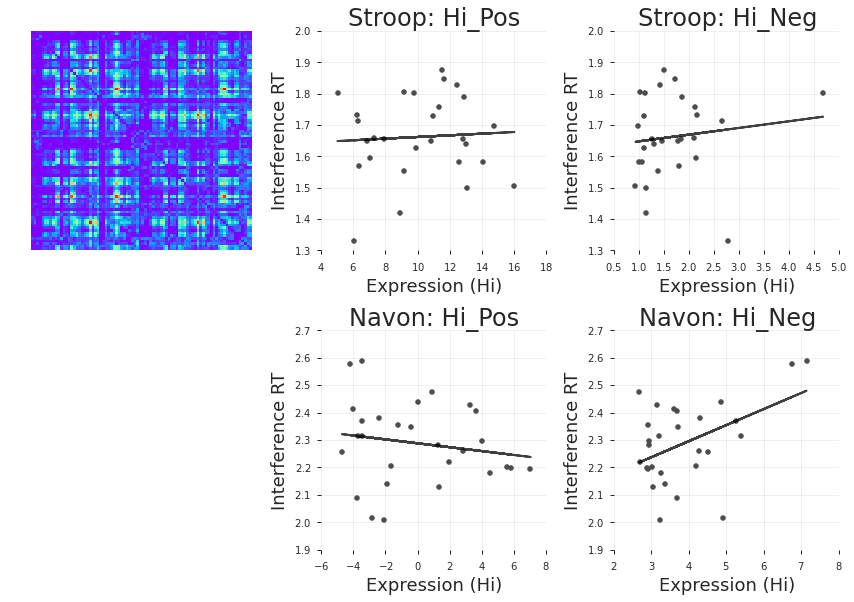





****************************** Subgraph 4 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

    Stroop: Hi_Pos: rho: -0.36170 pval: 0.03180 sig: 
    Stroop: Hi_Neg: rho: 0.26324 pval: 0.08790 sig: 
    Navon: Hi_Pos: rho: -0.16510 pval: 0.19900 sig: 
    Navon: Hi_Neg: rho: -0.17202 pval: 0.19970 sig: 


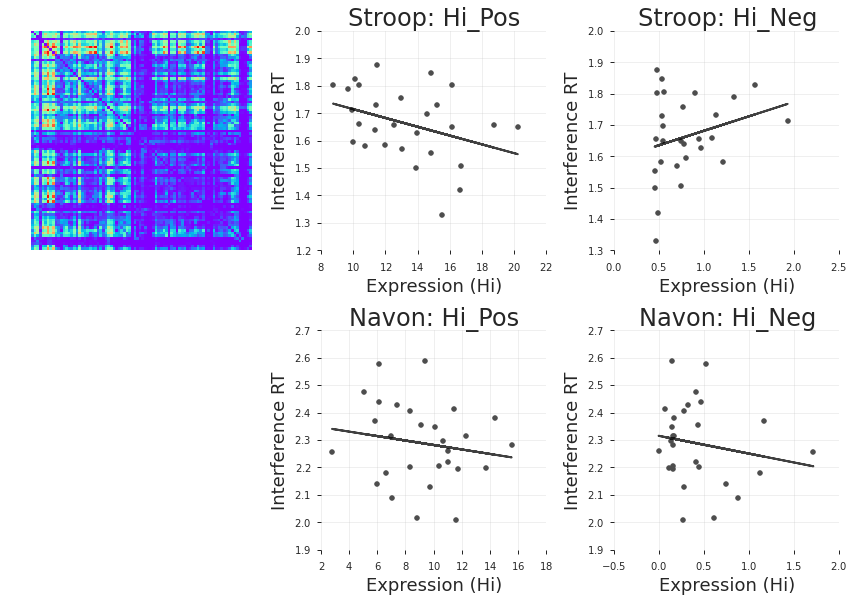





****************************** Subgraph 6 ******************************
    LH_frontalpole
    LH_parahippocampal
    RH_frontalpole
    LH_isthmuscingulate
    RH_parahippocampal
    LH_posteriorcingulate

    Stroop: Hi_Pos: rho: 0.35150 pval: 0.03250 sig: 
    Stroop: Hi_Neg: rho: 0.22657 pval: 0.13630 sig: 
    Navon: Hi_Pos: rho: 0.27524 pval: 0.07990 sig: 
    Navon: Hi_Neg: rho: -0.08973 pval: 0.32680 sig: 


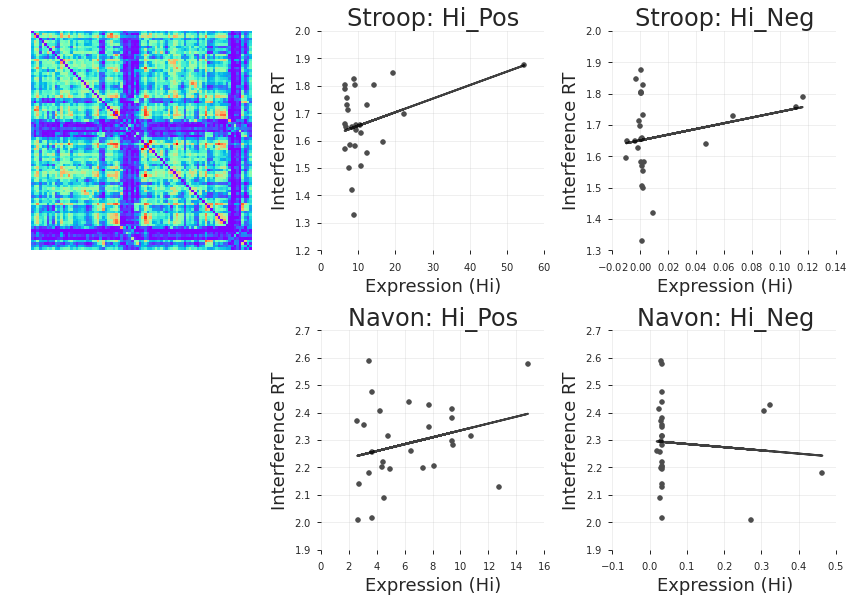





****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

    Stroop: Hi_Pos: rho: -0.34361 pval: 0.04440 sig: 
    Stroop: Hi_Neg: rho: 0.17038 pval: 0.20160 sig: 
    Navon: Hi_Pos: rho: 0.03274 pval: 0.43600 sig: 
    Navon: Hi_Neg: rho: -0.07929 pval: 0.34260 sig: 


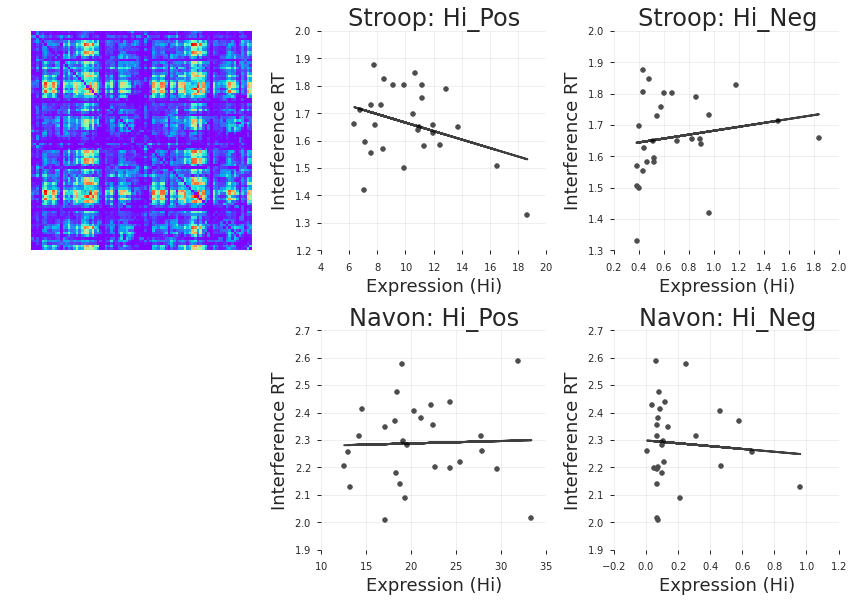





****************************** Subgraph 5 ******************************
    LH_parstriangularis
    LH_parsopercularis
    LH_caudalmiddlefrontal
    LH_bankssts
    LH_parsorbitalis
    LH_rostralmiddlefrontal

    Stroop: Hi_Pos: rho: -0.33229 pval: 0.04830 sig: 
    Stroop: Hi_Neg: rho: 0.17401 pval: 0.19120 sig: 
    Navon: Hi_Pos: rho: 0.13623 pval: 0.24720 sig: 
    Navon: Hi_Neg: rho: -0.32374 pval: 0.04940 sig: 


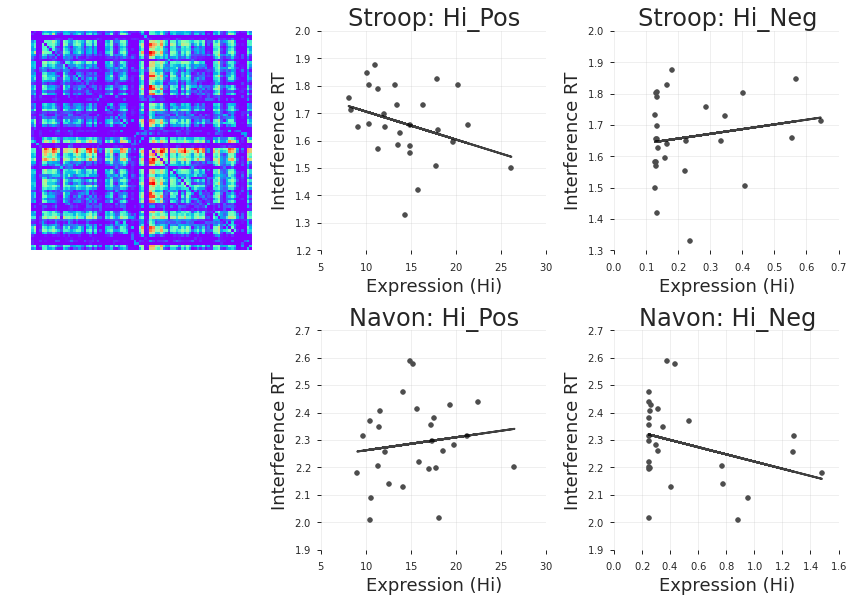





****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

    Stroop: Hi_Pos: rho: 0.00995 pval: 0.48090 sig: 
    Stroop: Hi_Neg: rho: -0.01560 pval: 0.46610 sig: 
    Navon: Hi_Pos: rho: 0.29851 pval: 0.06320 sig: 
    Navon: Hi_Neg: rho: 0.00091 pval: 0.50030 sig: 


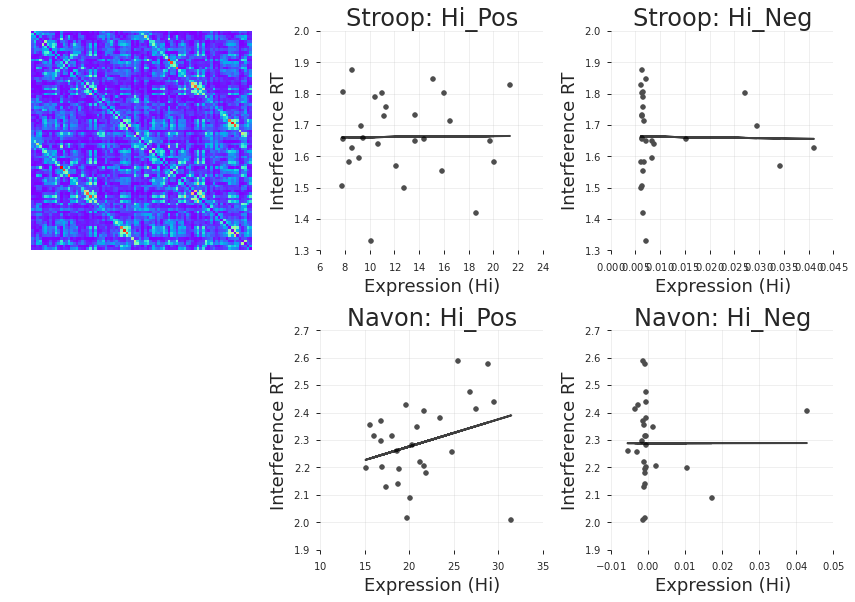





****************************** Subgraph 7 ******************************
    RH_paracentral
    LH_paracentral
    LH_cuneus
    LH_lingual
    RH_postcentral
    RH_precentral

    Stroop: Hi_Pos: rho: 0.05846 pval: 0.39760 sig: 
    Stroop: Hi_Neg: rho: 0.21792 pval: 0.13380 sig: 
    Navon: Hi_Pos: rho: -0.05458 pval: 0.38930 sig: 
    Navon: Hi_Neg: rho: 0.27742 pval: 0.08300 sig: 


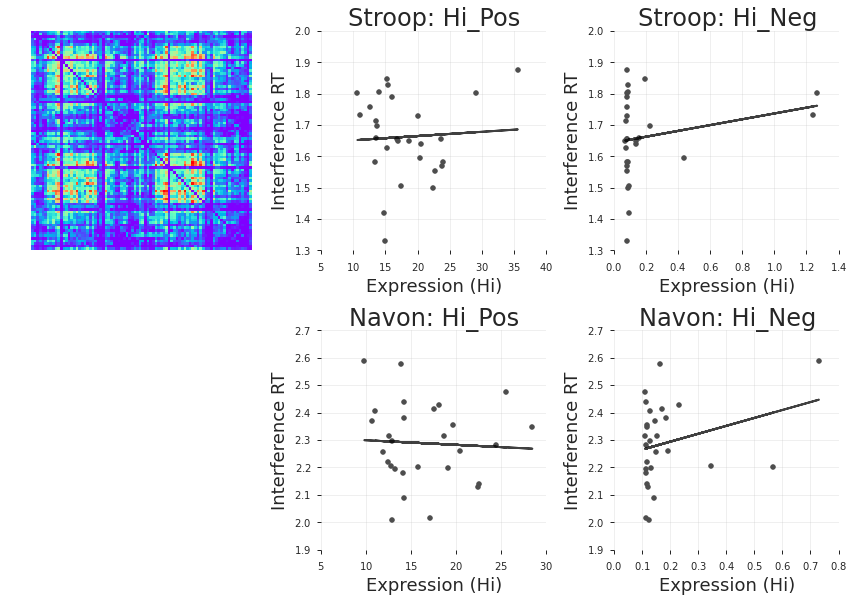





****************************** Subgraph 2 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

    Stroop: Hi_Pos: rho: 0.06333 pval: 0.37610 sig: 
    Stroop: Hi_Neg: rho: 0.07607 pval: 0.35430 sig: 
    Navon: Hi_Pos: rho: -0.06906 pval: 0.36460 sig: 
    Navon: Hi_Neg: rho: 0.22755 pval: 0.12690 sig: 


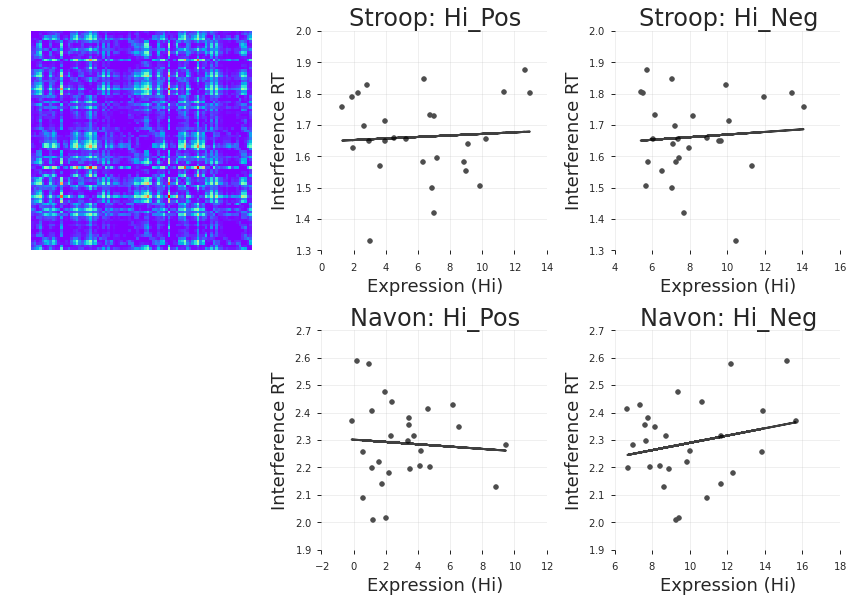





****************************** Subgraph 9 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Stroop: Hi_Pos: rho: -0.03276 pval: 0.43010 sig: 
    Stroop: Hi_Neg: rho: 0.17027 pval: 0.19340 sig: 
    Navon: Hi_Pos: rho: -0.19671 pval: 0.15570 sig: 
    Navon: Hi_Neg: rho: -0.03954 pval: 0.42250 sig: 


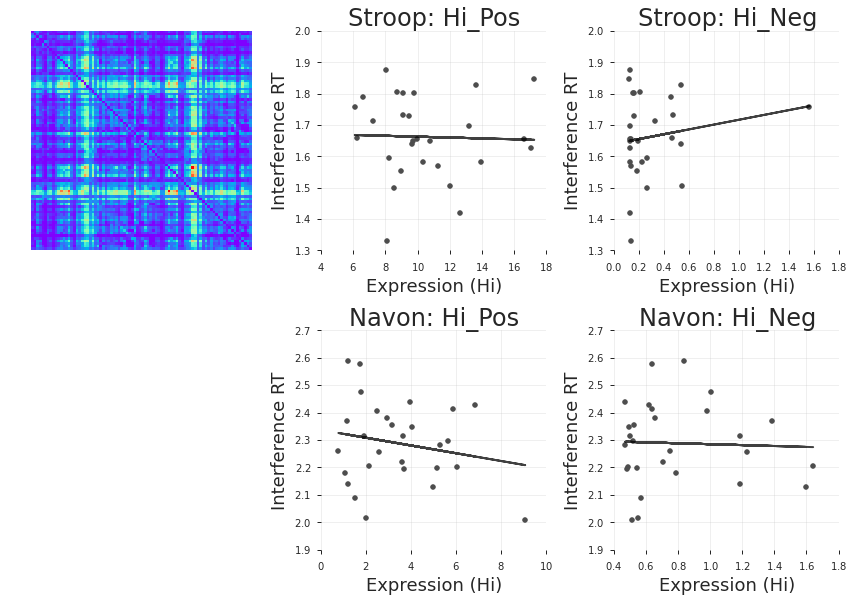





****************************** Subgraph 3 ******************************
    LH_paracentral
    LH_hyppocampus
    RH_paracentral
    LH_amygdala
    LH_rostralanteriorcingulate
    LH_medialorbitofrontal

    Stroop: Hi_Pos: rho: -0.10623 pval: 0.29720 sig: 
    Stroop: Hi_Neg: rho: 0.07930 pval: 0.34640 sig: 
    Navon: Hi_Pos: rho: -0.08440 pval: 0.33910 sig: 
    Navon: Hi_Neg: rho: -0.05559 pval: 0.39220 sig: 


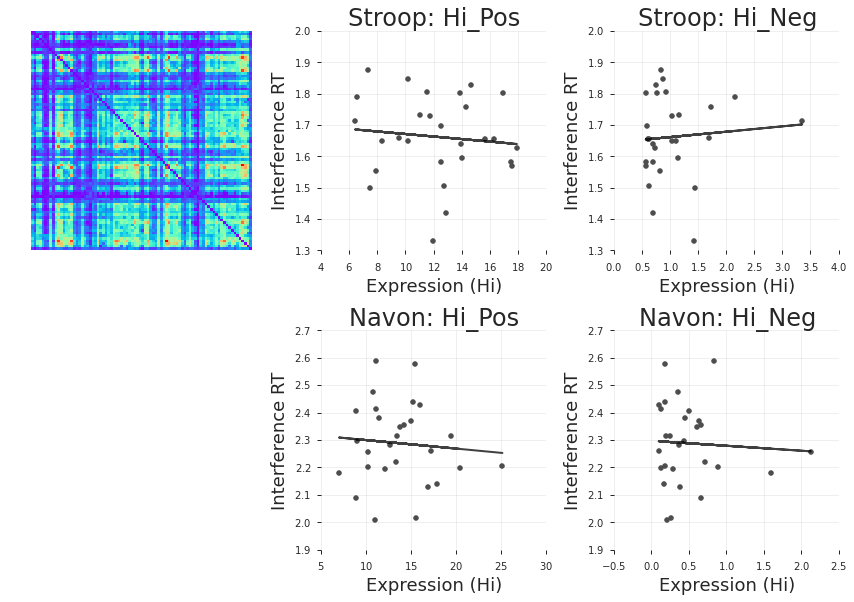

In [9]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Hi_Pos': ['adj_hi_pos_Stroop'],
                      'Hi_Neg': ['adj_hi_neg_Stroop']},
           'Navon' : {'Hi_Pos': ['adj_hi_pos_Navon'],
                      'Hi_Neg': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Hi_Pos', 'Hi_Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_interf_rt],
           'Navon': [navon_move, navon_interf_rt]}

sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)
            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            real_mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            
            
            real_m, real_b, real_rho, _, _ = stats.linregress(real_mean_subj_coef_nomove, beh_score_nomove)

            if real_rho == 0:
                pval = 1.0
            else:
                n_count = 0
                n_null = 10000
                for rnd_i in xrange(n_null):
                    null_fac_ix = np.random.randint(0, n_fac)
                    null_key_ix = np.random.randint(0, n_obs, size=len(key_ix))
                    subj_coef = fac_coef[null_fac_ix, null_key_ix].reshape(-1, 6)
                    mean_subj_coef = np.mean(subj_coef, axis=1)

                    m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
                    mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b

                    m, b, rho, _, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)

                    if (real_rho < 0) & (rho < real_rho):
                        n_count += 1

                    if (real_rho > 0) & (rho > real_rho):
                        n_count += 1

                pval = float(n_count) / float(n_null)                    
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (real_mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': real_rho,
                                     'pval': pval,
                                     'slope': real_m,
                                     "interc": real_b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)


# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi)')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting Cost RT (Hi-Lo)

0.0012500000
****************************** Subgraph 9 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

     Stroop: Pos: rho: 0.10574 pval: 0.30180 sig: 
     Stroop: Neg: rho: -0.04440 pval: 0.41560 sig: 
      Navon: Pos: rho: -0.32849 pval: 0.04900 sig: 
      Navon: Neg: rho: -0.08570 pval: 0.33530 sig: 


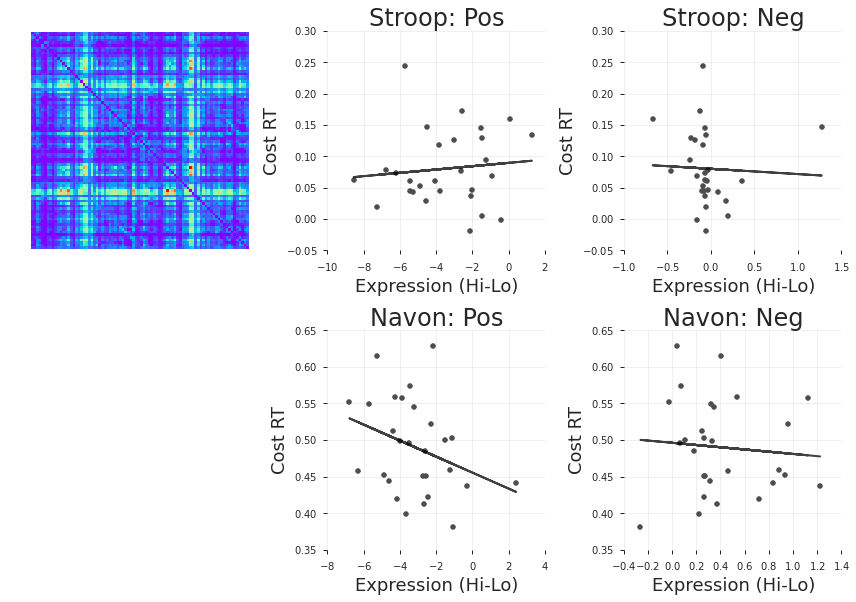





****************************** Subgraph 6 ******************************
    LH_frontalpole
    LH_parahippocampal
    RH_frontalpole
    LH_isthmuscingulate
    RH_parahippocampal
    LH_posteriorcingulate

     Stroop: Pos: rho: 0.20980 pval: 0.14420 sig: 
     Stroop: Neg: rho: 0.25083 pval: 0.10730 sig: 
      Navon: Pos: rho: 0.01485 pval: 0.46480 sig: 
      Navon: Neg: rho: -0.30961 pval: 0.06110 sig: 


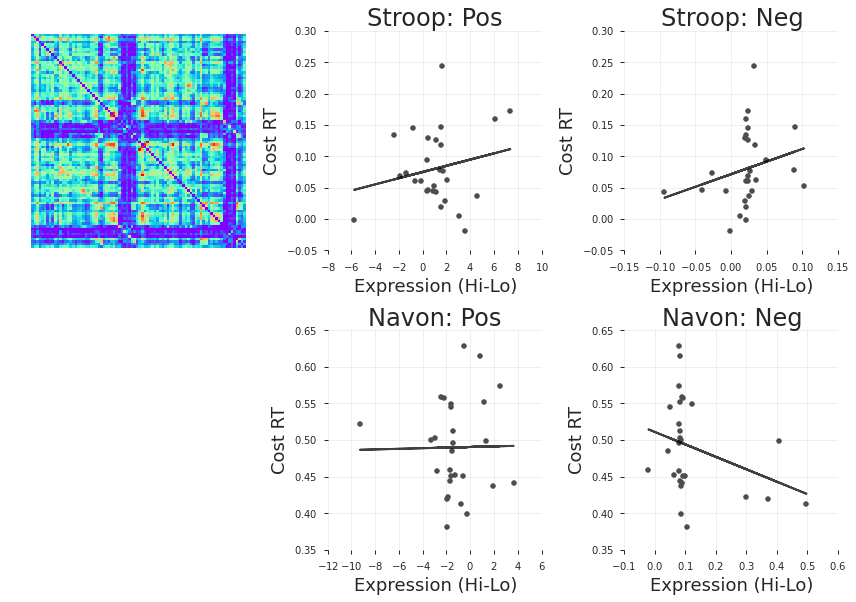





****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

     Stroop: Pos: rho: -0.27451 pval: 0.07990 sig: 
     Stroop: Neg: rho: -0.14989 pval: 0.22570 sig: 
      Navon: Pos: rho: 0.24242 pval: 0.11370 sig: 
      Navon: Neg: rho: -0.22029 pval: 0.13260 sig: 


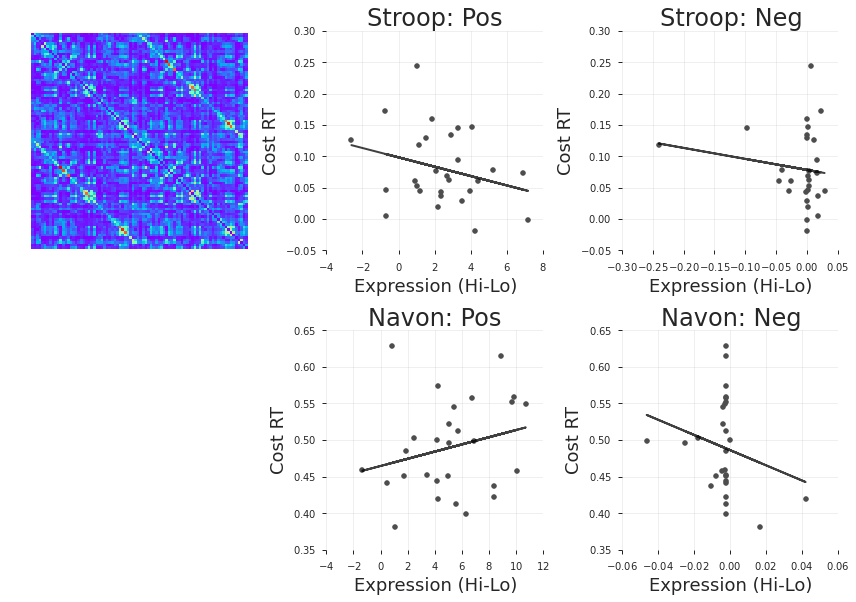





****************************** Subgraph 8 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

     Stroop: Pos: rho: -0.23037 pval: 0.12640 sig: 
     Stroop: Neg: rho: 0.07836 pval: 0.35200 sig: 
      Navon: Pos: rho: -0.06766 pval: 0.36170 sig: 
      Navon: Neg: rho: 0.27923 pval: 0.08380 sig: 


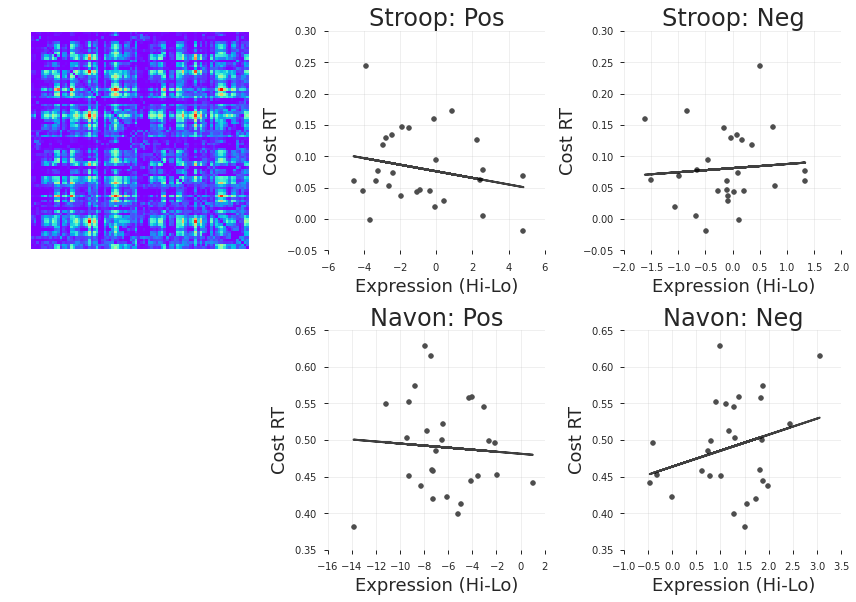





****************************** Subgraph 4 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

     Stroop: Pos: rho: 0.09245 pval: 0.32420 sig: 
     Stroop: Neg: rho: 0.23802 pval: 0.11810 sig: 
      Navon: Pos: rho: 0.11519 pval: 0.28470 sig: 
      Navon: Neg: rho: -0.25917 pval: 0.09260 sig: 


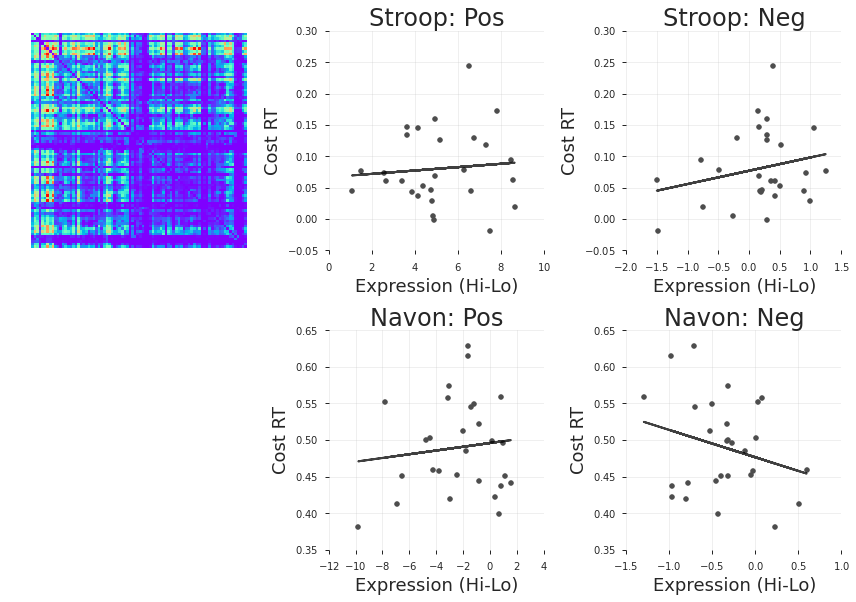





****************************** Subgraph 5 ******************************
    LH_parstriangularis
    LH_parsopercularis
    LH_caudalmiddlefrontal
    LH_bankssts
    LH_parsorbitalis
    LH_rostralmiddlefrontal

     Stroop: Pos: rho: -0.07696 pval: 0.34580 sig: 
     Stroop: Neg: rho: 0.15312 pval: 0.22560 sig: 
      Navon: Pos: rho: 0.06275 pval: 0.36950 sig: 
      Navon: Neg: rho: -0.20611 pval: 0.14920 sig: 


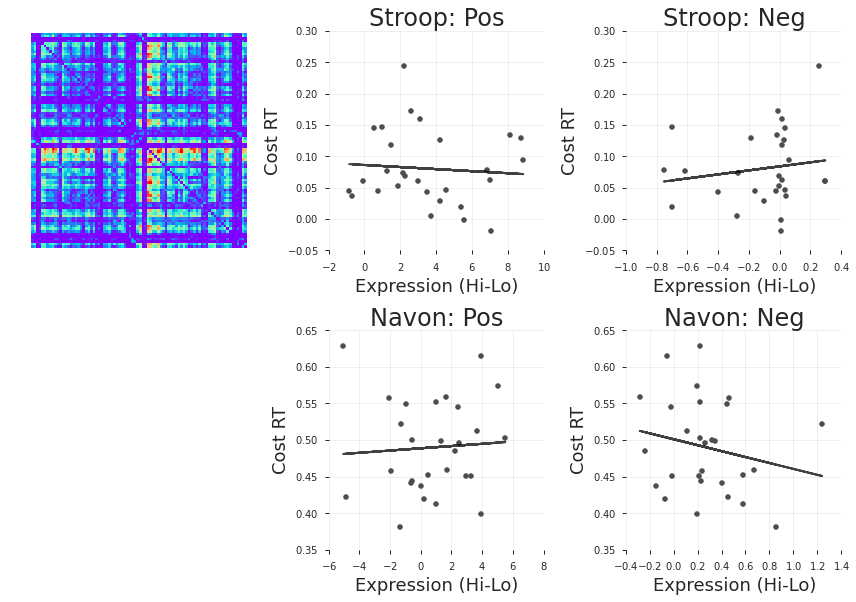





****************************** Subgraph 7 ******************************
    RH_paracentral
    LH_paracentral
    LH_cuneus
    LH_lingual
    RH_postcentral
    RH_precentral

     Stroop: Pos: rho: 0.06119 pval: 0.38380 sig: 
     Stroop: Neg: rho: -0.11054 pval: 0.29090 sig: 
      Navon: Pos: rho: 0.03755 pval: 0.42260 sig: 
      Navon: Neg: rho: 0.15111 pval: 0.21900 sig: 


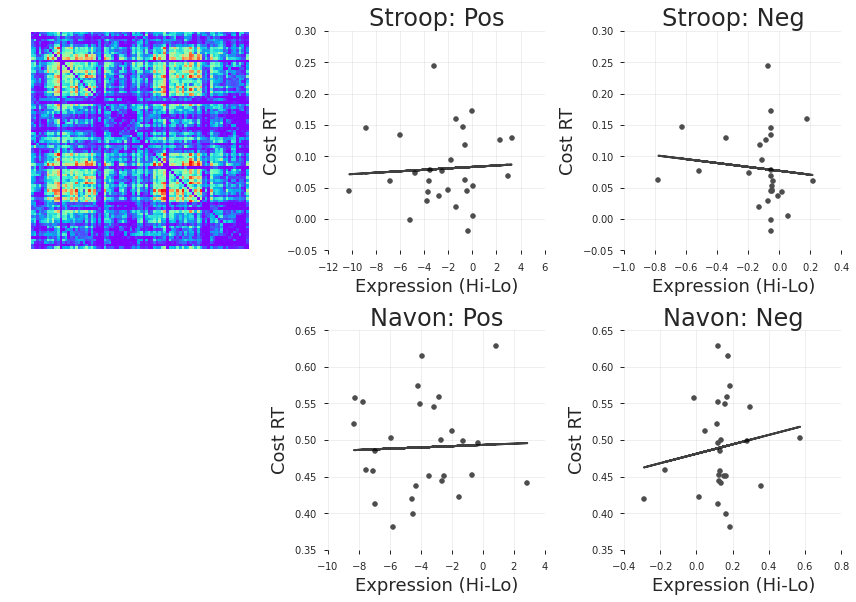





****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

     Stroop: Pos: rho: 0.07095 pval: 0.35830 sig: 
     Stroop: Neg: rho: 0.04987 pval: 0.40420 sig: 
      Navon: Pos: rho: 0.13317 pval: 0.25620 sig: 
      Navon: Neg: rho: 0.00448 pval: 0.48840 sig: 


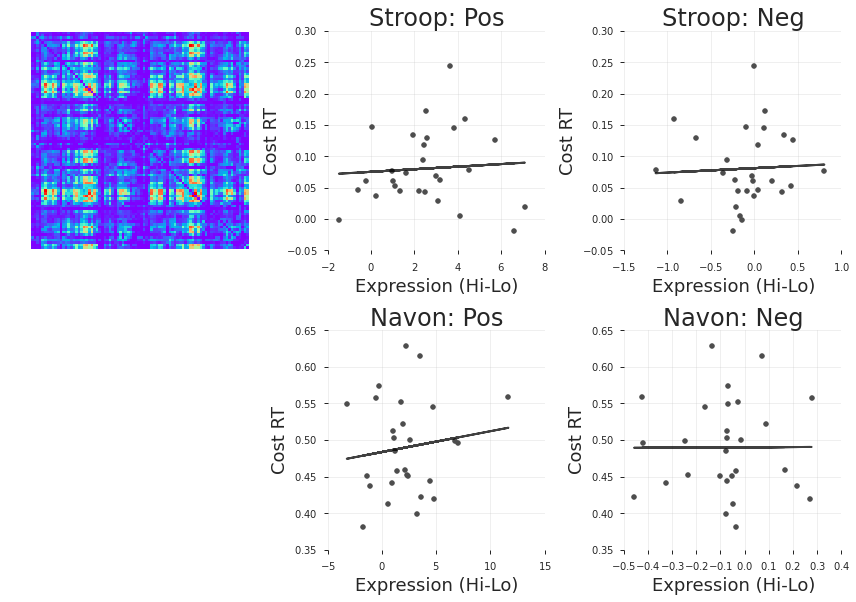





****************************** Subgraph 2 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

     Stroop: Pos: rho: 0.12484 pval: 0.27740 sig: 
     Stroop: Neg: rho: -0.04968 pval: 0.39230 sig: 
      Navon: Pos: rho: 0.00649 pval: 0.47700 sig: 
      Navon: Neg: rho: 0.11672 pval: 0.27170 sig: 


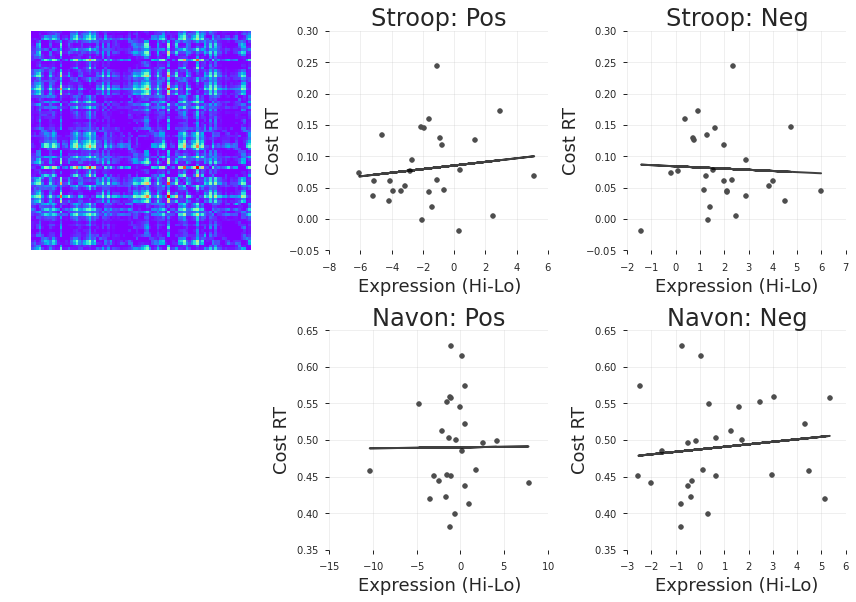





****************************** Subgraph 3 ******************************
    LH_paracentral
    LH_hyppocampus
    RH_paracentral
    LH_amygdala
    LH_rostralanteriorcingulate
    LH_medialorbitofrontal

     Stroop: Pos: rho: 0.04459 pval: 0.41570 sig: 
     Stroop: Neg: rho: 0.01849 pval: 0.45620 sig: 
      Navon: Pos: rho: -0.12109 pval: 0.27580 sig: 
      Navon: Neg: rho: 0.05320 pval: 0.40150 sig: 


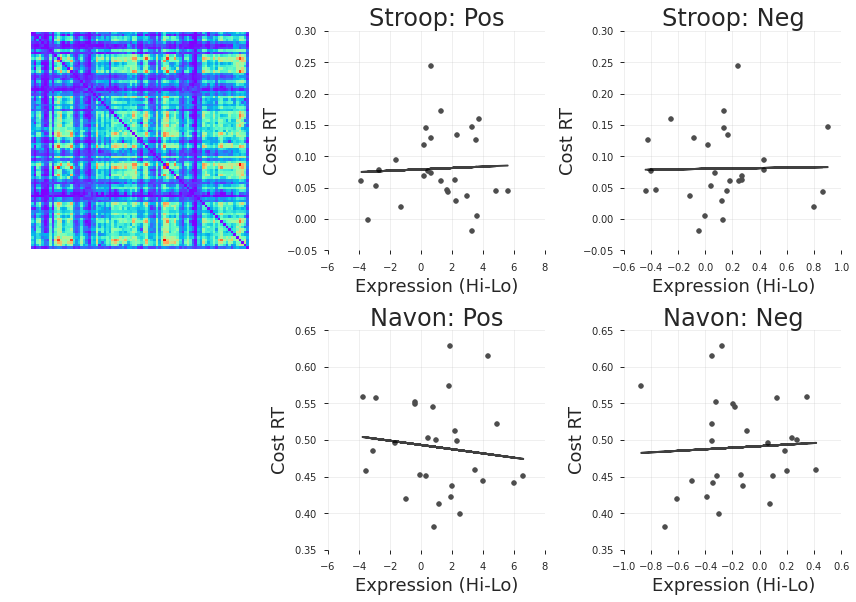

In [10]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Pos': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                      'Neg': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop']},
           'Navon' : {'Pos': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon'],
                      'Neg': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Pos', 'Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_cost_rt],
           'Navon': [navon_move, navon_cost_rt]}

sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_coef_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_coef_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)            
            mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            real_mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            
            
            real_m, real_b, real_rho, _, _ = stats.linregress(real_mean_subj_coef_nomove, beh_score_nomove)

            if real_rho == 0:
                pval = 1.0
            else:
                n_count = 0
                n_null = 10000
                for rnd_i in xrange(n_null):
                    null_fac_ix = np.random.randint(0, n_fac)
                    null_key_hi_ix = np.random.randint(0, n_obs, size=len(key_hi_ix))
                    null_key_lo_ix = np.random.randint(0, n_obs, size=len(key_lo_ix))
                    
                    subj_coef_hi = fac_coef[null_fac_ix, null_key_hi_ix].reshape(-1, 6)
                    subj_coef_lo = fac_coef[null_fac_ix, null_key_lo_ix].reshape(-1, 6)
                    mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)

                    m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
                    mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b

                    m, b, rho, _, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)

                    if (real_rho < 0) & (rho < real_rho):
                        n_count += 1

                    if (real_rho > 0) & (rho > real_rho):
                        n_count += 1

                pval = float(n_count) / float(n_null)                    
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (real_mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': real_rho,
                                     'pval': pval,
                                     'slope': real_m,
                                     "interc": real_b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi-Lo)')
        ax.set_ylabel('Cost RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting Interference Accuracy (Hi)

0.0012500000
****************************** Subgraph 5 ******************************
    LH_parstriangularis
    LH_parsopercularis
    LH_caudalmiddlefrontal
    LH_bankssts
    LH_parsorbitalis
    LH_rostralmiddlefrontal

    Stroop: Hi_Pos: rho: -0.16444 pval: 0.20750 sig: 
    Stroop: Hi_Neg: rho: 0.12713 pval: 0.26800 sig: 
    Navon: Hi_Pos: rho: -0.33138 pval: 0.05320 sig: 
    Navon: Hi_Neg: rho: 0.40531 pval: 0.01260 sig: 


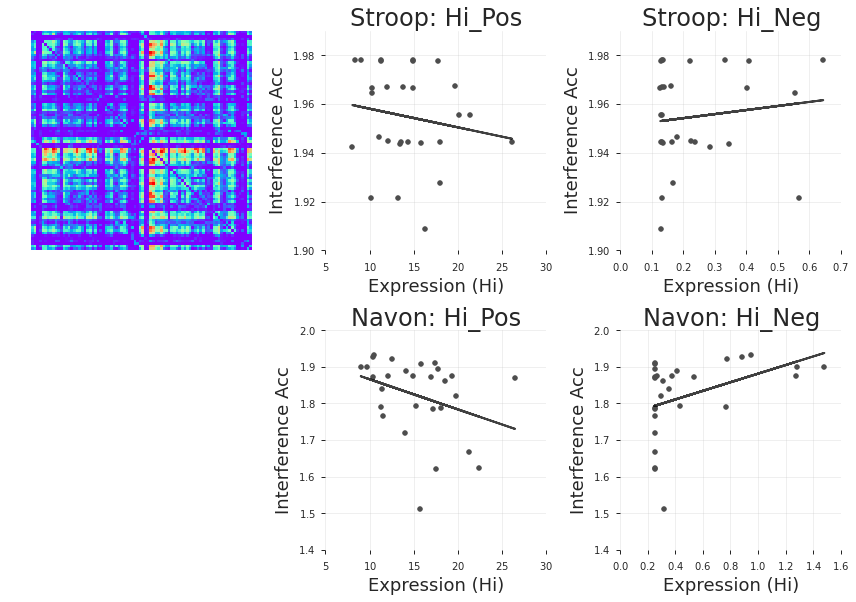





****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

    Stroop: Hi_Pos: rho: -0.19798 pval: 0.15870 sig: 
    Stroop: Hi_Neg: rho: 0.16502 pval: 0.21270 sig: 
    Navon: Hi_Pos: rho: -0.40394 pval: 0.02290 sig: 
    Navon: Hi_Neg: rho: 0.01969 pval: 0.47600 sig: 


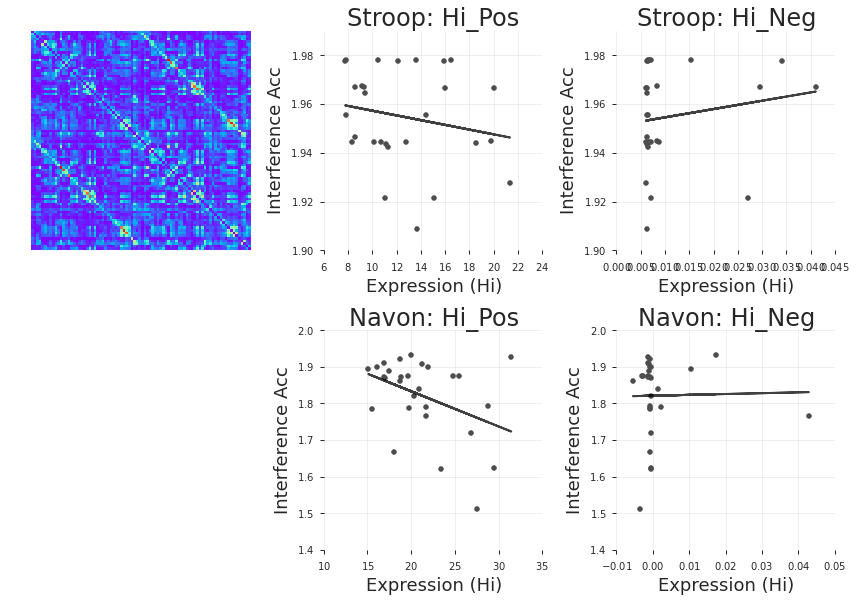





****************************** Subgraph 8 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

    Stroop: Hi_Pos: rho: -0.04298 pval: 0.40990 sig: 
    Stroop: Hi_Neg: rho: 0.12197 pval: 0.28300 sig: 
    Navon: Hi_Pos: rho: 0.28301 pval: 0.06850 sig: 
    Navon: Hi_Neg: rho: -0.08027 pval: 0.33070 sig: 


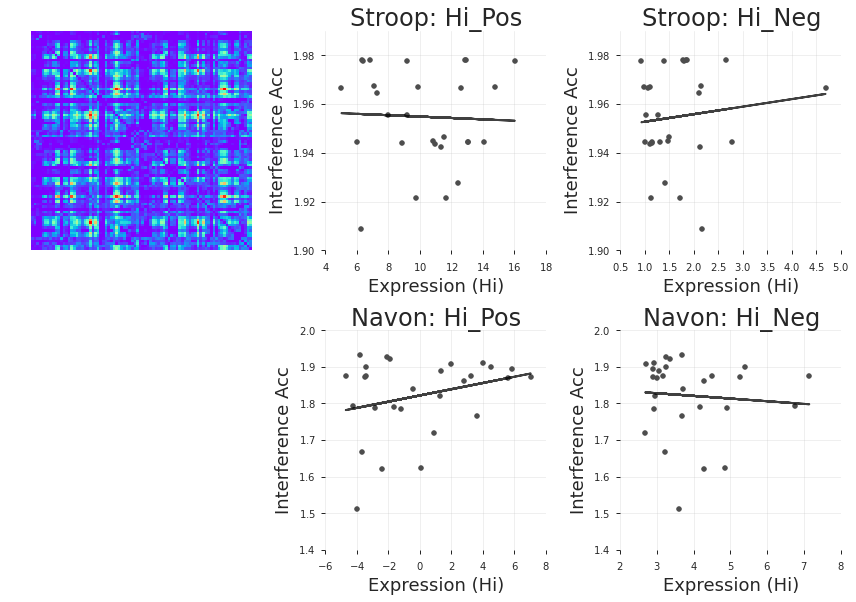





****************************** Subgraph 4 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

    Stroop: Hi_Pos: rho: -0.12003 pval: 0.27050 sig: 
    Stroop: Hi_Neg: rho: 0.10114 pval: 0.31250 sig: 
    Navon: Hi_Pos: rho: -0.17770 pval: 0.19260 sig: 
    Navon: Hi_Neg: rho: 0.26556 pval: 0.08380 sig: 


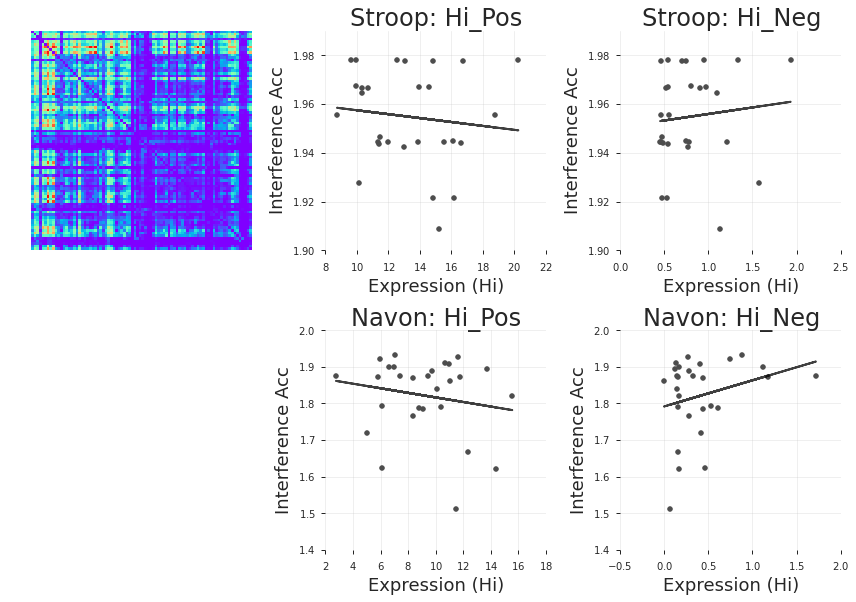





****************************** Subgraph 3 ******************************
    LH_paracentral
    LH_hyppocampus
    RH_paracentral
    LH_amygdala
    LH_rostralanteriorcingulate
    LH_medialorbitofrontal

    Stroop: Hi_Pos: rho: -0.12559 pval: 0.26560 sig: 
    Stroop: Hi_Neg: rho: 0.17687 pval: 0.19150 sig: 
    Navon: Hi_Pos: rho: 0.05350 pval: 0.40090 sig: 
    Navon: Hi_Neg: rho: 0.25887 pval: 0.08760 sig: 


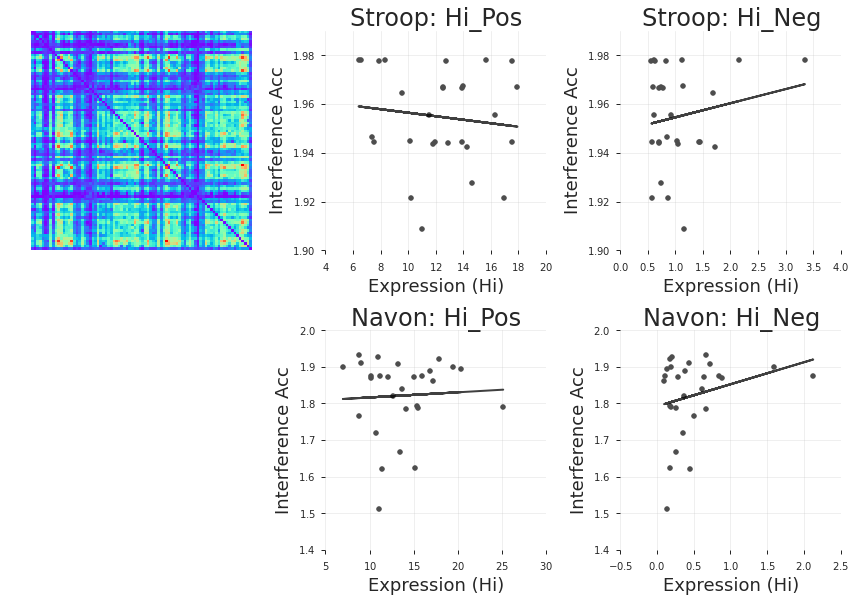





****************************** Subgraph 2 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

    Stroop: Hi_Pos: rho: -0.20213 pval: 0.15880 sig: 
    Stroop: Hi_Neg: rho: 0.20201 pval: 0.15820 sig: 
    Navon: Hi_Pos: rho: -0.13248 pval: 0.25520 sig: 
    Navon: Hi_Neg: rho: 0.25762 pval: 0.09040 sig: 


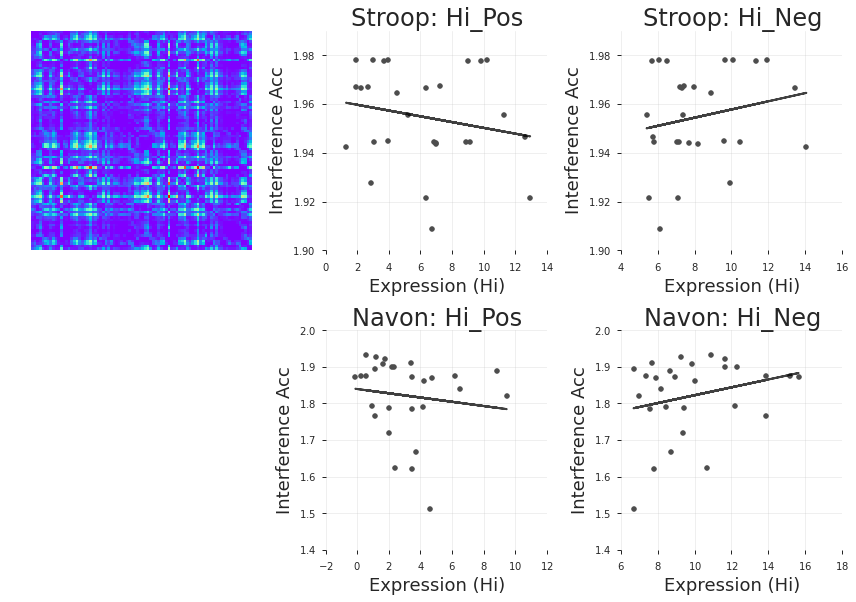





****************************** Subgraph 7 ******************************
    RH_paracentral
    LH_paracentral
    LH_cuneus
    LH_lingual
    RH_postcentral
    RH_precentral

    Stroop: Hi_Pos: rho: 0.00838 pval: 0.49250 sig: 
    Stroop: Hi_Neg: rho: -0.22979 pval: 0.12730 sig: 
    Navon: Hi_Pos: rho: -0.01221 pval: 0.46620 sig: 
    Navon: Hi_Neg: rho: 0.06994 pval: 0.38150 sig: 


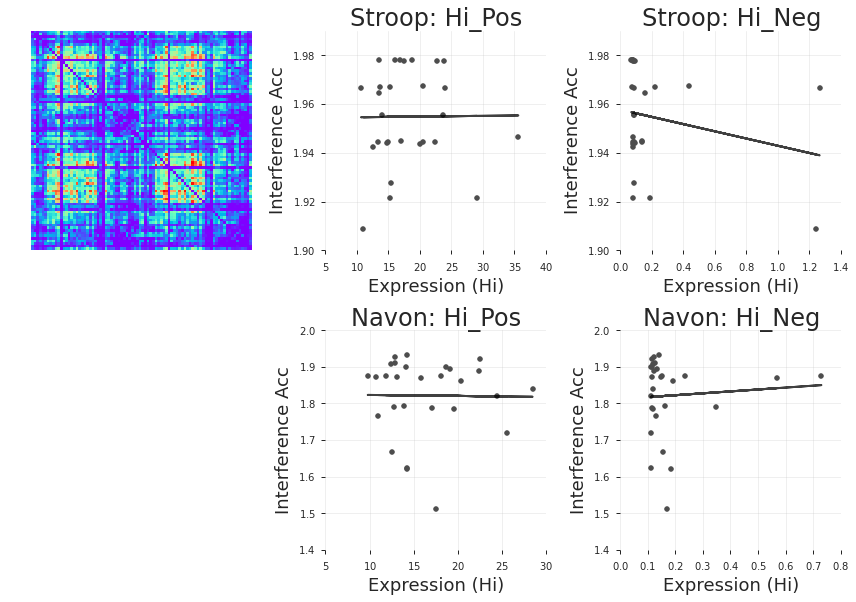





****************************** Subgraph 6 ******************************
    LH_frontalpole
    LH_parahippocampal
    RH_frontalpole
    LH_isthmuscingulate
    RH_parahippocampal
    LH_posteriorcingulate

    Stroop: Hi_Pos: rho: -0.14839 pval: 0.22630 sig: 
    Stroop: Hi_Neg: rho: -0.00514 pval: 0.48620 sig: 
    Navon: Hi_Pos: rho: -0.18930 pval: 0.17440 sig: 
    Navon: Hi_Neg: rho: 0.18247 pval: 0.18420 sig: 


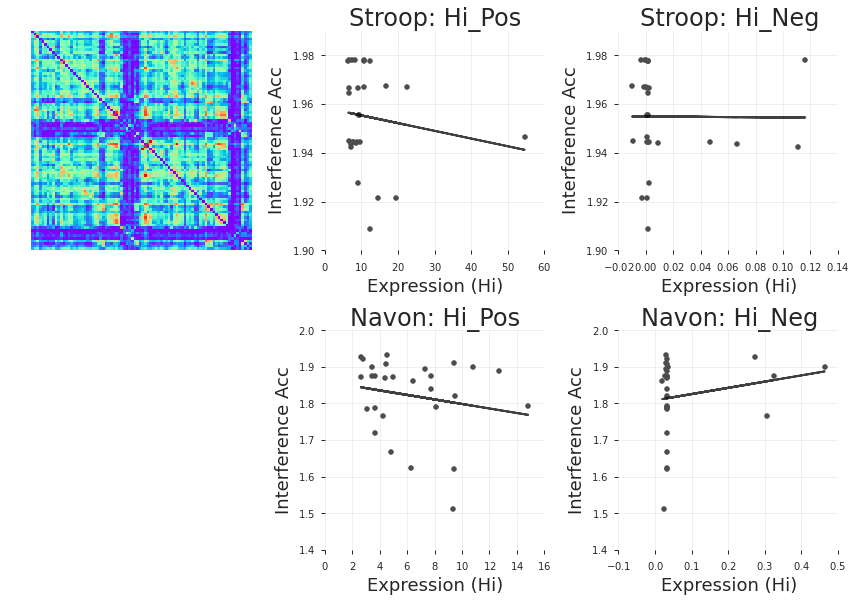





****************************** Subgraph 9 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Stroop: Hi_Pos: rho: -0.15993 pval: 0.21860 sig: 
    Stroop: Hi_Neg: rho: -0.14035 pval: 0.23540 sig: 
    Navon: Hi_Pos: rho: -0.03601 pval: 0.41830 sig: 
    Navon: Hi_Neg: rho: 0.17539 pval: 0.19710 sig: 


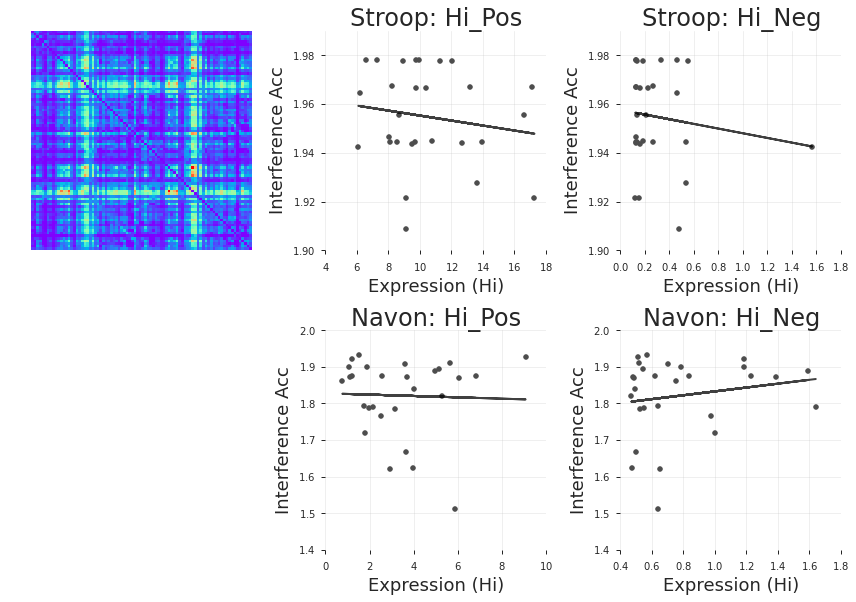





****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

    Stroop: Hi_Pos: rho: 0.16057 pval: 0.21430 sig: 
    Stroop: Hi_Neg: rho: -0.05013 pval: 0.39250 sig: 
    Navon: Hi_Pos: rho: -0.02406 pval: 0.44190 sig: 
    Navon: Hi_Neg: rho: 0.15096 pval: 0.22590 sig: 


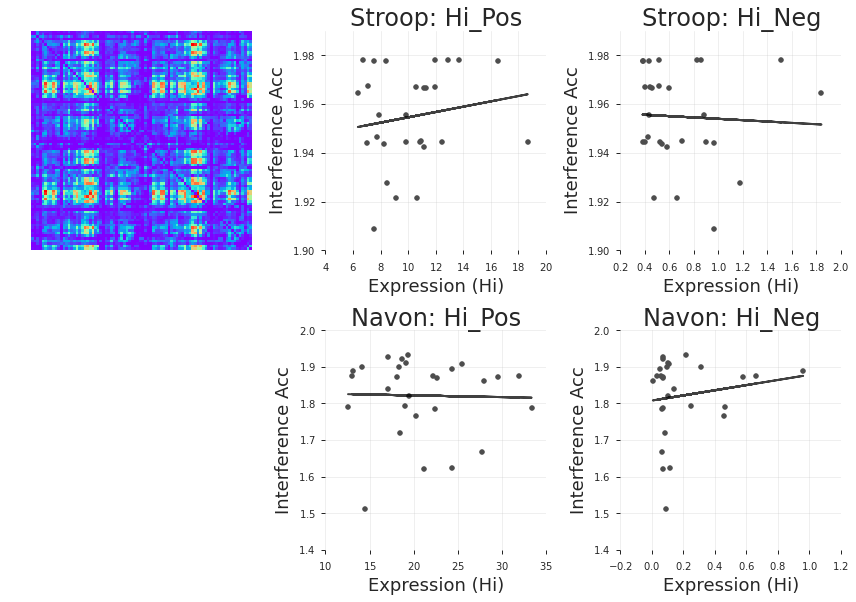

In [11]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Hi_Pos': ['adj_hi_pos_Stroop'],
                      'Hi_Neg': ['adj_hi_neg_Stroop']},
           'Navon' : {'Hi_Pos': ['adj_hi_pos_Navon'],
                      'Hi_Neg': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Hi_Pos', 'Hi_Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_interf_acc],
           'Navon': [navon_move, navon_interf_acc]}

sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)
            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            real_mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            
            
            real_m, real_b, real_rho, _, _ = stats.linregress(real_mean_subj_coef_nomove, beh_score_nomove)

            if real_rho == 0:
                pval = 1.0
            else:
                n_count = 0
                n_null = 10000
                for rnd_i in xrange(n_null):
                    null_fac_ix = np.random.randint(0, n_fac)
                    null_key_ix = np.random.randint(0, n_obs, size=len(key_ix))
                    subj_coef = fac_coef[null_fac_ix, null_key_ix].reshape(-1, 6)
                    mean_subj_coef = np.mean(subj_coef, axis=1)

                    m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
                    mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b

                    m, b, rho, _, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)

                    if (real_rho < 0) & (rho < real_rho):
                        n_count += 1

                    if (real_rho > 0) & (rho > real_rho):
                        n_count += 1

                pval = float(n_count) / float(n_null)                    
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (real_mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': real_rho,
                                     'pval': pval,
                                     'slope': real_m,
                                     "interc": real_b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi)')
        ax.set_ylabel('Interference Acc')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting Cost Accuracy (Hi-Lo)

0.0012500000
****************************** Subgraph 6 ******************************
    LH_frontalpole
    LH_parahippocampal
    RH_frontalpole
    LH_isthmuscingulate
    RH_parahippocampal
    LH_posteriorcingulate

     Stroop: Pos: rho: 0.23616 pval: 0.11070 sig: 
     Stroop: Neg: rho: -0.10114 pval: 0.30520 sig: 
      Navon: Pos: rho: 0.39562 pval: 0.02020 sig: 
      Navon: Neg: rho: -0.11177 pval: 0.28540 sig: 


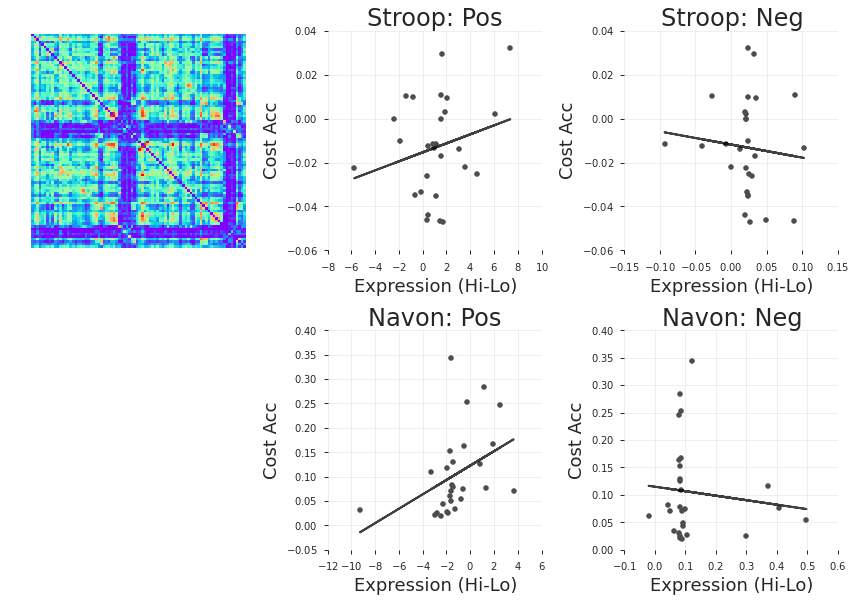





****************************** Subgraph 3 ******************************
    LH_paracentral
    LH_hyppocampus
    RH_paracentral
    LH_amygdala
    LH_rostralanteriorcingulate
    LH_medialorbitofrontal

     Stroop: Pos: rho: 0.23092 pval: 0.12740 sig: 
     Stroop: Neg: rho: 0.22575 pval: 0.12480 sig: 
      Navon: Pos: rho: 0.06163 pval: 0.37580 sig: 
      Navon: Neg: rho: -0.36554 pval: 0.03250 sig: 


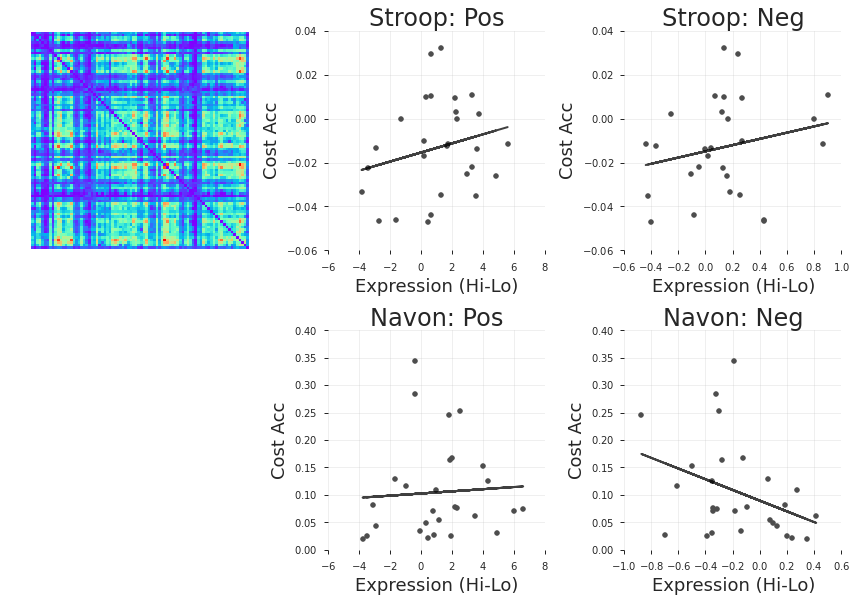





****************************** Subgraph 9 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

     Stroop: Pos: rho: -0.15837 pval: 0.21330 sig: 
     Stroop: Neg: rho: 0.21357 pval: 0.14250 sig: 
      Navon: Pos: rho: -0.33389 pval: 0.04580 sig: 
      Navon: Neg: rho: -0.26109 pval: 0.09390 sig: 


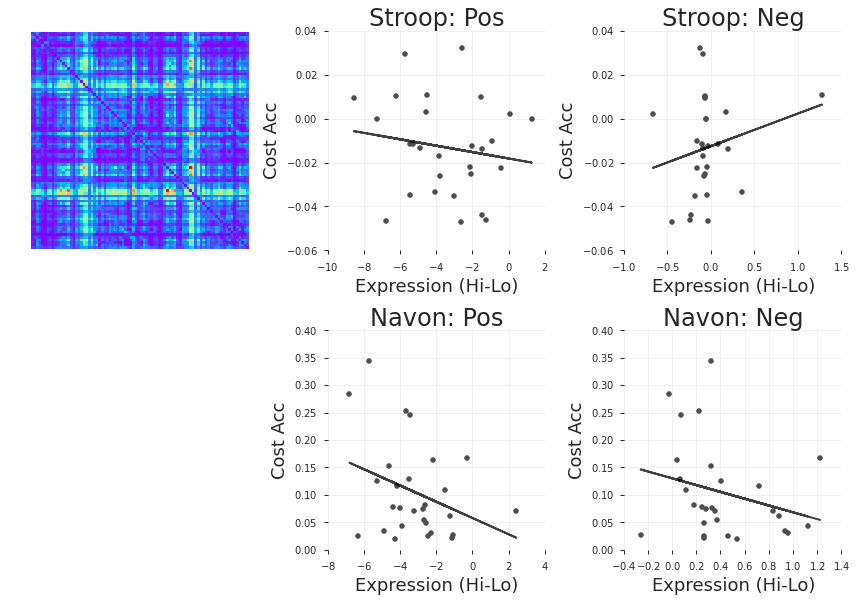





****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

     Stroop: Pos: rho: -0.06021 pval: 0.38270 sig: 
     Stroop: Neg: rho: 0.08571 pval: 0.33120 sig: 
      Navon: Pos: rho: 0.30955 pval: 0.06440 sig: 
      Navon: Neg: rho: 0.02828 pval: 0.43830 sig: 


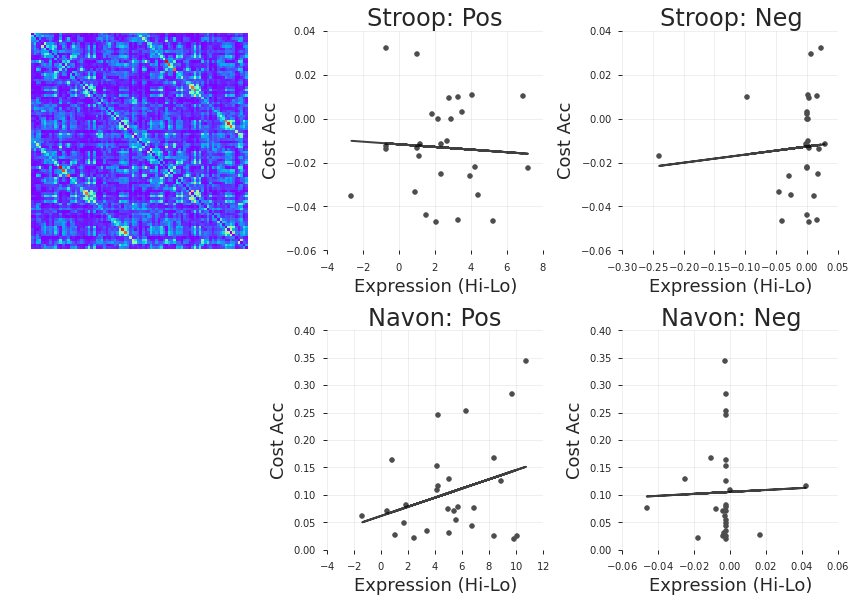





****************************** Subgraph 8 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

     Stroop: Pos: rho: 0.05215 pval: 0.39440 sig: 
     Stroop: Neg: rho: -0.25030 pval: 0.10690 sig: 
      Navon: Pos: rho: -0.27180 pval: 0.07970 sig: 
      Navon: Neg: rho: 0.12360 pval: 0.26940 sig: 


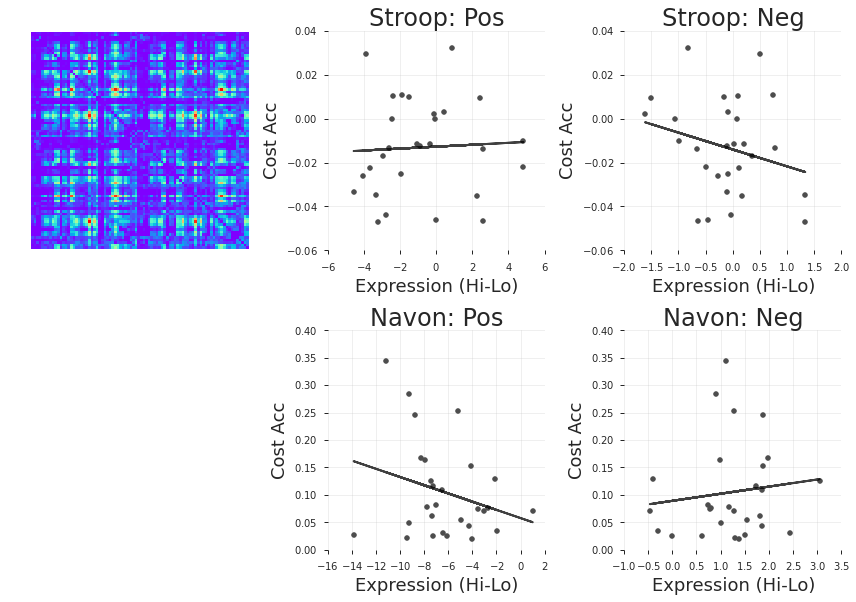





****************************** Subgraph 2 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

     Stroop: Pos: rho: 0.10048 pval: 0.30900 sig: 
     Stroop: Neg: rho: 0.08429 pval: 0.33430 sig: 
      Navon: Pos: rho: -0.07105 pval: 0.36590 sig: 
      Navon: Neg: rho: -0.22267 pval: 0.12580 sig: 


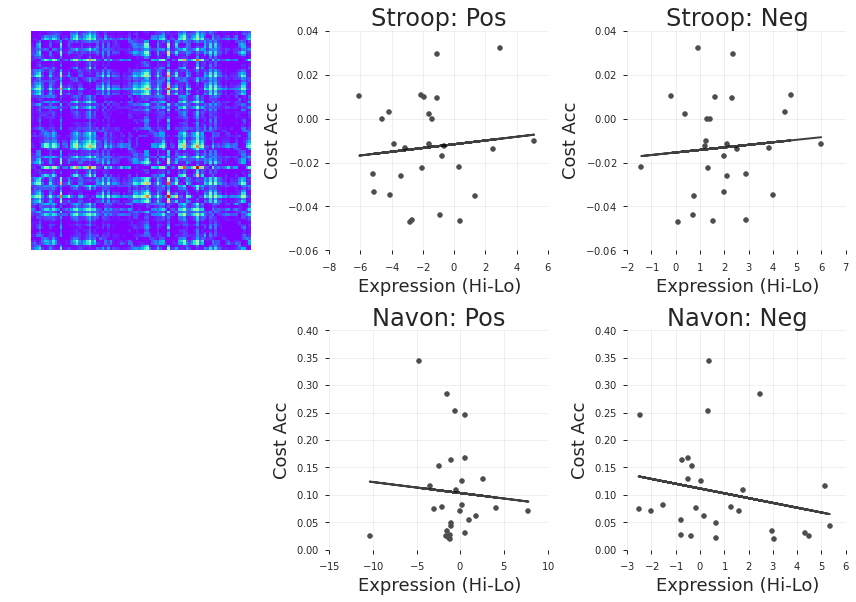





****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

     Stroop: Pos: rho: 0.11310 pval: 0.28580 sig: 
     Stroop: Neg: rho: 0.00093 pval: 0.49800 sig: 
      Navon: Pos: rho: -0.22737 pval: 0.13220 sig: 
      Navon: Neg: rho: 0.13752 pval: 0.24140 sig: 


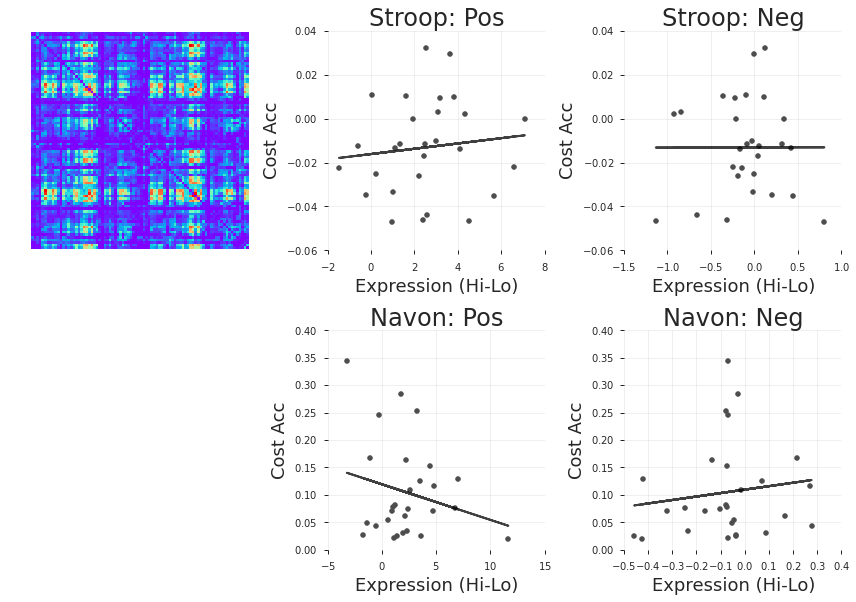





****************************** Subgraph 5 ******************************
    LH_parstriangularis
    LH_parsopercularis
    LH_caudalmiddlefrontal
    LH_bankssts
    LH_parsorbitalis
    LH_rostralmiddlefrontal

     Stroop: Pos: rho: -0.21520 pval: 0.13750 sig: 
     Stroop: Neg: rho: 0.07965 pval: 0.35380 sig: 
      Navon: Pos: rho: 0.10466 pval: 0.30010 sig: 
      Navon: Neg: rho: -0.18592 pval: 0.17820 sig: 


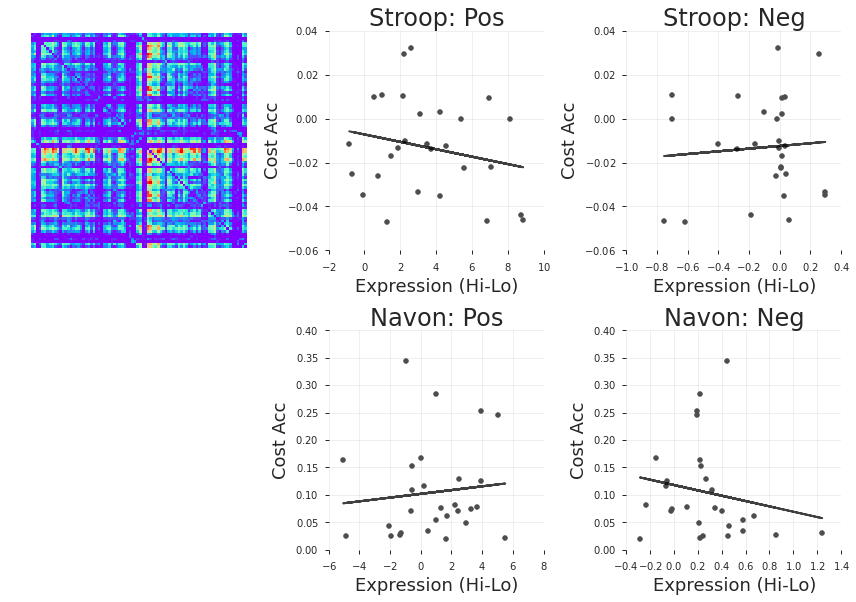





****************************** Subgraph 4 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

     Stroop: Pos: rho: 0.16830 pval: 0.19900 sig: 
     Stroop: Neg: rho: 0.07300 pval: 0.35730 sig: 
      Navon: Pos: rho: 0.08127 pval: 0.34100 sig: 
      Navon: Neg: rho: -0.12949 pval: 0.26090 sig: 


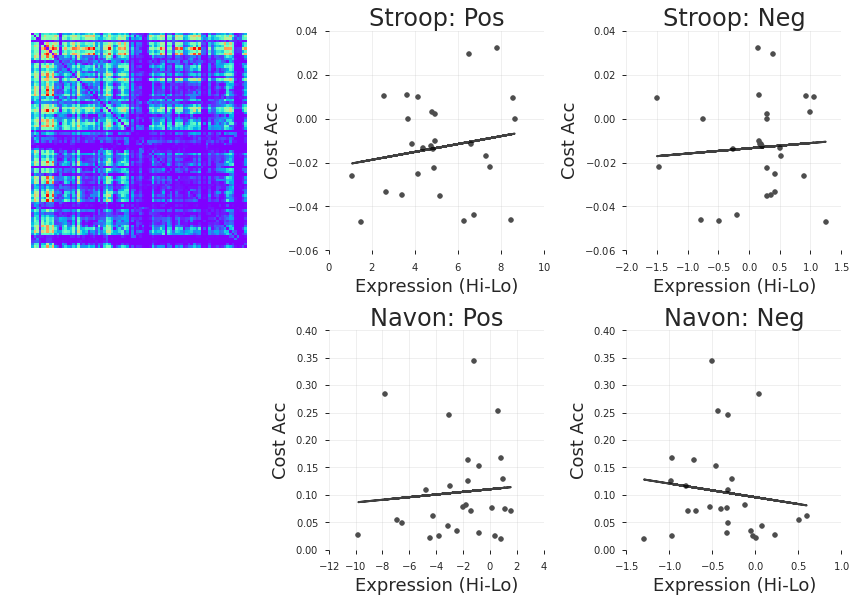





****************************** Subgraph 7 ******************************
    RH_paracentral
    LH_paracentral
    LH_cuneus
    LH_lingual
    RH_postcentral
    RH_precentral

     Stroop: Pos: rho: -0.05777 pval: 0.38640 sig: 
     Stroop: Neg: rho: -0.08708 pval: 0.33090 sig: 
      Navon: Pos: rho: 0.01849 pval: 0.45850 sig: 
      Navon: Neg: rho: 0.01244 pval: 0.46030 sig: 


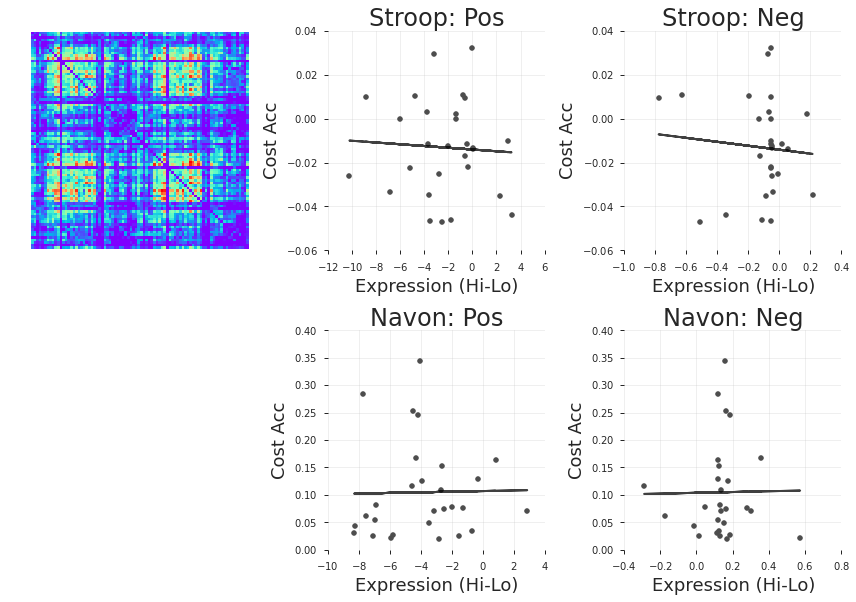

In [12]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Pos': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                      'Neg': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop']},
           'Navon' : {'Pos': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon'],
                      'Neg': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Pos', 'Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_cost_acc],
           'Navon': [navon_move, navon_cost_acc]}

sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_coef_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_coef_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)            
            mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            real_mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            
            
            real_m, real_b, real_rho, _, _ = stats.linregress(real_mean_subj_coef_nomove, beh_score_nomove)

            if real_rho == 0:
                pval = 1.0
            else:
                n_count = 0
                n_null = 10000
                for rnd_i in xrange(n_null):
                    null_fac_ix = np.random.randint(0, n_fac)
                    null_key_hi_ix = np.random.randint(0, n_obs, size=len(key_hi_ix))
                    null_key_lo_ix = np.random.randint(0, n_obs, size=len(key_lo_ix))
                    
                    subj_coef_hi = fac_coef[null_fac_ix, null_key_hi_ix].reshape(-1, 6)
                    subj_coef_lo = fac_coef[null_fac_ix, null_key_lo_ix].reshape(-1, 6)
                    mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)

                    m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
                    mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b

                    m, b, rho, _, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)

                    if (real_rho < 0) & (rho < real_rho):
                        n_count += 1

                    if (real_rho > 0) & (rho > real_rho):
                        n_count += 1

                pval = float(n_count) / float(n_null)                    
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (real_mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': real_rho,
                                     'pval': pval,
                                     'slope': real_m,
                                     "interc": real_b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)        

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi-Lo)')
        ax.set_ylabel('Cost Acc')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')